<h1><center>Sur l'Ajustement de Valorisation IPV</center></h1>


# Introduction

Le but de ce travail est d'impliciter la volatilité du sous jacent dans le modèle de Black Scholes et de faire un Ajustement de Valorisation à Valeur Principale d'un call *(le prix que nous donne le pricer)* pour s'approcher de la **Juste Valeur**.

$$\text{Juste Valeur}=\text{Valorisation Principale}+\text{Ajustement de Valorisation (IPV)}$$

Soit $C(\sigma)$ le prix fourni par le pricer d'un call européen de sous jacent une action $A$ dont le prix est $S_0$ à l'émission du contrat, de strike $K=100$ et de maturité $T=1$ an et $C_m$ le prix consensus d'un call avec les mêmes caractéristiques founi par Totem.

On définit la fonction $f$ comme suit :

$$f(\sigma)=C(\sigma)-C_m$$

L'objectif est alors de trouver $\sigma '$ telle que

$$f(\sigma ')=C(\sigma ')-C_m=0$$



Pour faire notre premiere éstimation du prix de ce call nous avons utilisé une volatilité historique $\sigma_h=0.3$

Pour trouver $\sigma '$ nous allons utiliser l'algorithme de Newton Raphson

# Modèle de Black Scholes

## Calcul du taux sans risque



On considère une obligation de maturité M=5ans un notionnel N=100.
On suppose que le coupon de l’obligation est de la forme $c_0=ref + s_0$
Avec ref un taux de référence par exemple le taux LIBOR
## Définition du taux libor
### Bootstraping des Zero Coupon
A partir des swap rates on definit $∀n\in \mathbb{N}$

$$Df_n=\frac{1-S_n\sum_{i=1}^{n-1}δDf_i}{1+δS_n}$$
#### Definition du taux LIBOR
On définit alors les taux libor comme,

$$L_i:=\frac{1}{δ}\Big(\frac{Df_{i-1}}{Df_i}-1\Big)$$

de telle sorte que

$$Df_i=Df_{i-1}\frac{1}{(1+δL_i)}$$

+ d'un coté on peut investir $Df_i$ à $t=0$ puis recevoir $1$ à $t_i$
+ d'un autre coté, si on peut investir $Df_{i-1}$ à $t=0$ puis recevoir $1$ à $t_{i-1}$ que l'on reinvesti au taux libor sur l'interval $[t_{i-1},t_i]$ qui nous raporte $(1+δL_i)$ à $t_i$, alors on peut repliquer 1 à $t_i$ si on investi $Df_{i-1}\frac{1}{(1+δL_i)}$ à $t=0$

Par absence d'opportunité d'arbitrage on a égalité des deux stratégies et c'est ce qui définit le taux libor.

#### Valeur de la jambe flotante du swap
On a l'equation d'equilibre suivante

$$\sum_{i=1}^n\delta L_iDf_i=1-Df_n$$
#### Relation de bootstraping

On a

$$S_n=\frac{1-Df_n}{δ\sum_{i=1}^nDf_i}$$

Donc,

$$S_n\sum_{i=1}^n\delta Df_i=1-Df_n$$



finalement on trouve que
$$S_n\sum_{i=1}^n\delta Df_i=\sum_{i=1}^n\delta L_iDf_i$$

c'est equivalent à dire que

$$\delta Df_nL_n=S_n\sum_{i=1}^{n}\delta Df_i-\sum_{i=1}^{n-1}\delta L_iDf_i$$


On va résoudre pour chaque $n$ alors l'équation:
$$\delta Df_nx=S_n\sum_{i=1}^{n}\delta Df_i-\sum_{i=1}^{n-1}\delta L_iDf_i$$

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:



delta = 1.0
swap_maturities = np.array([1, 2, 3, 4,5,6,7,8,9,10])
swap_rates = np.array([0.050, 0.052, 0.053, 0.054,0.053, 0.052, 0.051, 0.05,0.045,0.043])



zc_prices = [1.0]
for i, S in enumerate(swap_rates):
    n = i + 1
    sum_discounted = sum(delta * zc_prices[j] for j in range(n))
    Pn = (1 - S * sum_discounted) / (1 + delta * S)
    zc_prices.append(Pn)

zc_prices = np.array(zc_prices)
times = np.arange(0, len(zc_prices))


libor_def = []
for i in range(1, len(zc_prices)):
    L = (1 / delta) * (zc_prices[i - 1] / zc_prices[i] - 1)
    libor_def.append(L)


libor_eq = []

for n, Sn in enumerate(swap_rates, start=1):
    rhs = sum(delta * libor_eq[i] * zc_prices[i + 1] for i in range(n - 1))


    lhs = Sn * sum(delta * zc_prices[i + 1] for i in range(n))


    def equation(Ln):
        return rhs + delta * Ln * zc_prices[n] - lhs

    sol = root_scalar(equation, bracket=[-0.1, 0.5], method='brentq')
    libor_eq.append(sol.root)


results = pd.DataFrame({
    "Maturity": [f"T{i}" for i in range(1, len(zc_prices))],
    "Swap Rate": swap_rates,
    "ZC Price": zc_prices[1:],
    "Libor (ZC def)": libor_def,
    "Libor (Eq solving)": libor_eq,
    "Difference": np.abs((np.array(libor_def) - np.array(libor_eq))/np.array(libor_def))*100
})

print(results)


  Maturity  Swap Rate        ZC Price  Libor (ZC def)  Libor (Eq solving)  \
0       T1      0.050  0.904761904762  0.105263157895      0.050000000000   
1       T2      0.052  0.856418613073  0.056448202960      0.054112896406   
2       T3      0.053  0.810690819140  0.056405960019      0.055172444138   
3       T4      0.054  0.765767502660  0.058664433166      0.057358553775   
4       T5      0.053  0.731343914054  0.047068947924      0.048436293684   
5       T6      0.052  0.700012259323  0.044758722885      0.046187269295   
6       T7      0.051  0.671533067875  0.042409216777      0.043898346722   
7       T8      0.050  0.645689139005  0.040025342395      0.041574075275   
8       T9      0.045  0.651789689096 -0.009359691005     -0.001688504910   
9      T10      0.043  0.639756186878  0.018809512850      0.021935703797   

        Difference  
0  52.500000000000  
1   4.137078651685  
2   2.186853801609  
3   2.226015526774  
4   2.904984751786  
5   3.191660346641  
6   3

# CIM Basis
On a l'egalité suivante pour la frequence 1 pour un swap fix-flotant

$$K^1Bpv^1=\sum_{i=0}^M\frac{1}{\delta_i^{t^1}}\big(\frac{Df_{i-1}^{t^1}}{Df_i^{t^1}}-1\big)Df_i^{t^1}\delta_i^{t^1}$$

On a aussi l'égalité suivante pour un swap flotant-flotant

$$\sum_{i=0}^M\Big(\frac{1}{\delta_i^{t^1}}\big(\frac{Df_{i-1}^{t^1}}{Df_i^{t^1}}-1\big)+Cim^{1}_{2}\Big)Df_i^{t^1}\delta_i^{t^1}=\sum_{j=0}^M\frac{1}{\delta_j^{t^2}}\big(\frac{Df_{j-1}^{t^2}}{Df_j^{t^2}}-1\big)Df_j^{t^2}\delta_j^{t^2}$$

Donc,

$$K^1Bpv^1+Cim^{1}_{2}Bpv^1=NPV^2$$

Donc,

$$K^1=\frac{NPV^2}{Bpv^1}-Cim^{1}_{2}$$

On a aussi

$$K^1=K^2\frac{Bpv^2}{Bpv^1}-Cim^{1}_{2}$$

On peut voir que

$$Cim^{1}_{2}=\frac{\sum_{j=0}^M\frac{1}{\delta_j^{t^2}}\big(\frac{Df_{j-1}^{t^2}}{Df_j^{t^2}}-1\big)Df_j^{t^2}\delta_j^{t^2}-\sum_{i=0}^M\frac{1}{\delta_i^{t^1}}\big(\frac{Df_{i-1}^{t^1}}{Df_i^{t^1}}-1\big)Df_i^{t^1}\delta_i^{t^1}}{Bpv^{1}}$$


## Relation de composition

On a
$$\begin{cases}
Cim^{3M}_{6M}=\frac{\sum_{j=0}^M\frac{1}{\delta_j^{6M}}\big(\frac{Df_{j-1}^{6M}}{Df_j^{6M}}-1\big)Df_j^{6M}\delta_j^{6M}-\sum_{i=0}^M\frac{1}{\delta_i^{3M}}\big(\frac{Df_{i-1}^{3M}}{Df_i^{3M}}-1\big)Df_i^{3M}\delta_i^{3M}}{Bpv^{3M}}\\
Cim^{6M}_{1Y}=\frac{\sum_{i=0}^M\frac{1}{\delta_i^{1Y}}\big(\frac{Df_{i-1}^{1Y}}{Df_i^{1Y}}-1\big)Df_i^{1Y}\delta_i^{1Y}-\sum_{j=0}^M\frac{1}{\delta_j^{6M}}\big(\frac{Df_{j-1}^{6M}}{Df_j^{6M}}-1\big)Df_j^{6M}\delta_j^{6M}}{Bpv^{6M}}\\
Cim^{3M}_{1Y}=\frac{\sum_{i=0}^M\frac{1}{\delta_i^{1Y}}\big(\frac{Df_{i-1}^{1Y}}{Df_i^{1Y}}-1\big)Df_i^{1Y}\delta_i^{1Y}-\sum_{j=0}^M\frac{1}{\delta_j^{3M}}\big(\frac{Df_{j-1}^{3M}}{Df_j^{3M}}-1\big)Df_j^{3M}\delta_j^{3M}}{Bpv^{3M}}\\
\end{cases}$$
Donc
$$Cim^{3M}_{1Y}=Cim^{3M}_{6M}+Cim^{6M}_{1Y}\frac{Bpv^{6M}}{Bpv^{3M}}$$

In [ ]:
import numpy as np
from datetime import datetime, timedelta

# ==============================
# Schedule
# ==============================
class Schedule:
    def __init__(self, start_date: datetime, end_date: datetime, frequency: str = "3M"):
        self.start_date = start_date
        self.end_date = end_date
        self.frequency = frequency.upper()
        self.dates = self._generate_dates()

    def _generate_dates(self):
        freq_to_days = {"1M":30,"3M":90,"6M":180,"1Y":365}
        step_days = freq_to_days.get(self.frequency)
        if step_days is None:
            raise ValueError("Fréquence non supportée")
        dates=[]
        current=self.start_date
        while current < self.end_date:
            current += timedelta(days=step_days)
            if current <= self.end_date:
                dates.append(current)
        return dates

    def year_fractions(self):
        return np.array([(d - self.start_date).days/365 for d in self.dates])

# ==============================
# Bootstrap Discount Curve
# ==============================
def bootstrap_dfs(maturities, swap_rates, delta):
    dfs = {0.0: 1.0}
    max_maturity = max(maturities)
    times = np.arange(delta, max_maturity+delta, delta)
    maturity_idx = 0
    for t in times:
        while maturity_idx < len(maturities)-1 and t > maturities[maturity_idx]:
            maturity_idx += 1
        Sn = swap_rates[maturity_idx]
        N = int(round(t/delta))
        sum_prev = sum(delta * dfs[i*delta] for i in range(1,N))
        Pn = (1 - Sn*sum_prev)/(1 + Sn*delta)
        dfs[round(t,8)] = Pn
    return dfs

class DiscountCurve:
    def __init__(self, maturities, swap_rates, delta=0.25):
        self.delta = delta
        self.dfs = bootstrap_dfs(maturities, swap_rates, delta)

    def df(self,t):
        if t==0:
            return 1.0
        t = round(t,20)
        if t in self.dfs:
            return self.dfs[t]
        times = sorted(self.dfs.keys())
        return float(np.interp(t,times,[self.dfs[x] for x in times]))

# ==============================
# Libor Curve
# ==============================
class LiborCurve:
    def __init__(self, discount_curve: DiscountCurve, frequency="3M"):
        self.discount_curve = discount_curve
        self.frequency = frequency.upper()
        self.delta = {"1M":1/12,"3M":0.25,"6M":0.5,"1Y":1.0}[self.frequency]

    def forward_rate(self, t):
        df1 = self.discount_curve.df(t)
        df2 = self.discount_curve.df(t+self.delta)
        return (df1/df2 -1)/self.delta

# ==============================
# Swap
# ==============================
class Swap:
    def __init__(self, notional, schedule: Schedule, discount_curve: DiscountCurve, libor_curve: LiborCurve):
        self.notional = notional
        self.schedule = schedule
        self.discount_curve = discount_curve
        self.libor_curve = libor_curve
        self.delta = libor_curve.delta
        self.fixed_rate = self.par_rate()

    def par_rate(self):
        times = self.schedule.year_fractions()
        if len(times)==0:
            return 0.0
        fixed_leg = sum(self.discount_curve.df(t)*self.delta for t in times)
        times_full = np.concatenate(([0.0], times))
        float_leg = sum((self.discount_curve.df(times_full[i]) - self.discount_curve.df(times_full[i+1])) for i in range(len(times)))
        return float_leg/fixed_leg if fixed_leg!=0 else 0.0

    def npv_floating_leg(self):
        times = self.schedule.year_fractions()
        times_full = np.concatenate(([0.0], times))
        npv = 0.0
        for i in range(len(times)):
            fwd = (self.discount_curve.df(times_full[i])/self.discount_curve.df(times_full[i+1]) - 1)/self.delta
            df = self.discount_curve.df(times_full[i+1])
            npv += fwd * df * self.delta
        return npv*self.notional

    def CashFlowsFixed(self):
      times = self.schedule.year_fractions()
      cashF=[self.fixed_rate*self.delta*self.notional*self.discount_curve.df(t) for t in times]
      return cashF

    def CashFlowsFloating(self):
      times = self.schedule.year_fractions()
      times_full = np.concatenate(([0.0], times))
      cashF=[]
      for i in range(len(times)):
          fwd = (self.discount_curve.df(times_full[i])/self.discount_curve.df(times_full[i+1]) - 1)/self.delta
          df = self.discount_curve.df(times_full[i+1])
          cashF.append(fwd * df * self.delta*self.notional)
      return cashF



# ==============================
# Spread functions
# ==============================
def bpv_from_schedule(discount_curve: DiscountCurve, schedule: Schedule, delta: float):
    return sum(discount_curve.df(t)*delta for t in schedule.year_fractions())

def terminal_df(discount_curve: DiscountCurve, schedule: Schedule):
    times = schedule.year_fractions()
    if len(times)==0:
        return 1.0
    return discount_curve.df(times[-1])

def composition_spread(libor_curve_a: LiborCurve, libor_curve_b: LiborCurve,
                       discount_curve: DiscountCurve, schedule_a: Schedule, schedule_b: Schedule):
    delta_a = libor_curve_a.delta
    delta_b = libor_curve_b.delta

    P_last_a = terminal_df(discount_curve, schedule_a)
    P_last_b = terminal_df(discount_curve, schedule_b)

    leg_a = 1.0 - P_last_a
    leg_b = 1.0 - P_last_b

    bpv_a = bpv_from_schedule(discount_curve, schedule_a, delta_a)
    bpv_b = bpv_from_schedule(discount_curve, schedule_b, delta_b)

    spread_ab = (leg_b - leg_a)/bpv_a

    swap_a = Swap(1, schedule_a, discount_curve, libor_curve_a)
    swap_b = Swap(1, schedule_b, discount_curve, libor_curve_b)
    spread_ab_swap = (swap_b.npv_floating_leg() - swap_a.npv_floating_leg())/bpv_a

    return float(spread_ab), float(spread_ab_swap), float(bpv_a), float(bpv_b)

def composition_chain(spread_3m_6m, spread_6m_1y, bpv_3m, bpv_6m):
    return spread_3m_6m + spread_6m_1y*(bpv_6m/bpv_3m)

# ==============================
# Test complet
# ==============================
if __name__=="__main__":
    start_date = datetime.today()
    maturities = [0.25,0.5,1.0,2.0,3.0]
    swap_rates = [0.01,0.012,0.015,0.020,0.025]
    delta = 0.25

    discount_curve = DiscountCurve(maturities, swap_rates, delta)

    # Calibration initiale des swaps marché vs modèle
    print("=== Calibration Check ===")
    libor_curve = LiborCurve(discount_curve, "3M")
    for T, S in zip(maturities, swap_rates):
        schedule = Schedule(start_date, start_date + timedelta(days=int(T*365)), frequency="3M")
        swap = Swap(1e6, schedule, discount_curve, libor_curve)
        print(f"Swap marché {T:.2f}Y: {S:.6f} | Swap modèle: {swap.fixed_rate:.6f}")

    # Test LiborCurves 3M,6M,1Y + Spreads
    libor_curve_3m = LiborCurve(discount_curve, "3M")
    libor_curve_6m = LiborCurve(discount_curve, "6M")
    libor_curve_1y = LiborCurve(discount_curve, "1Y")

    schedule3M = Schedule(start_date, start_date + timedelta(days=365), "3M")
    schedule6M = Schedule(start_date, start_date + timedelta(days=365), "6M")
    schedule1Y = Schedule(start_date, start_date + timedelta(days=365), "1Y")

    spread_3m_6m, spread_3m_6mSwap, bpv_3m, bpv_6m = composition_spread(libor_curve_3m, libor_curve_6m, discount_curve, schedule3M, schedule6M)
    spread_6m_1y, spread_6m_1ySwap, bpv_6m_check, bpv_1y = composition_spread(libor_curve_6m, libor_curve_1y, discount_curve, schedule6M, schedule1Y)
    spread_3m_1y_direct, spread_3m_1y_directSwap, bpv_3m_check, bpv_1y_check = composition_spread(libor_curve_3m, libor_curve_1y, discount_curve, schedule3M, schedule1Y)
    spread_3m_1y_via_chain = composition_chain(spread_3m_6m, spread_6m_1y, bpv_3m, bpv_6m)

    swap3M = Swap(1, schedule3M, discount_curve, libor_curve_3m)
    swap6M = Swap(1, schedule6M, discount_curve, libor_curve_6m)
    swap1Y = Swap(1, schedule1Y, discount_curve, libor_curve_1y)


    print("\n=== Floating leg NPV / spreads ===")
    print(swap6M.npv_floating_leg())
    print(swap1Y.npv_floating_leg()/bpv_6m - spread_6m_1y, swap6M.fixed_rate)
    print(swap6M.fixed_rate, swap1Y.fixed_rate*bpv_1y/bpv_6m - spread_6m_1y)

    print("\n=== Spreads (bps) ===")
    print("Spread 3M-6M:", spread_3m_6m*10000, spread_3m_6mSwap*10000)
    print("Spread 6M-1Y:", spread_6m_1y*10000, spread_6m_1ySwap*10000)
    print("Spread 3M-1Y direct:", spread_3m_1y_direct*10000, spread_3m_1y_directSwap*10000)
    print("Spread 3M-1Y via chain:", spread_3m_1y_via_chain*10000)
    print("Absolute difference direct vs chain:", abs(spread_3m_1y_direct - spread_3m_1y_via_chain))

    print(swap3M.CashFlowsFixed(),sum(swap3M.CashFlowsFixed()))
    print(swap3M.CashFlowsFloating(),sum(swap3M.CashFlowsFloating()))


=== Calibration Check ===
Swap marché 0.25Y: 0.010000 | Swap modèle: 0.009863
Swap marché 0.50Y: 0.012000 | Swap modèle: 0.011808
Swap marché 1.00Y: 0.015000 | Swap modèle: 0.014794
Swap marché 2.00Y: 0.020000 | Swap modèle: 0.019725
Swap marché 3.00Y: 0.025000 | Swap modèle: 0.024656

=== Floating leg NPV / spreads ===
0.014668143916517972
0.014820404106916228 0.014820404106916252
0.014820404106916252 0.014820404106916252

=== Spreads (bps) ===
Spread 3M-6M: 0.0 1.7495815966725204e-14
Spread 6M-1Y: 2.045250825832557 2.0452508258331004
Spread 3M-1Y direct: 2.04157641249263 2.04157641249319
Spread 3M-1Y via chain: 2.04157641249263
Absolute difference direct vs chain: 2.710505431213761e-20
[0.0036893478842786914, 0.0036767005895058675, 0.0036579001653912462, 0.003644195277342247] 0.014668143916518052
[0.002459604413623421, 0.003419625317672328, 0.005083332636753406, 0.003705581548468814] 0.014668143916517969


## Structure de la dette
A l’émission de l’obligation on actualise les flux future avec le taux c_0=ref + s_0 pour être au pair (Question?)

On a alors le prix initial de l’obligation :
 $$ \pi_0=\pi(s_0)=N.\sum_{i=0}^M B(t_i)(ref+s_0)+N.B(t_n)$$

 avec,

 $$B(t_i)=\frac{1}{(1+ref+s_0)^{t_i}}$$




 On pose maintenant

 $$\pi(s)=N.\sum_{i=0}^M B(t_i)(ref+s)+N.B(t_n)$$

 On a alors,

  $$\pi'(s)=N.\sum_{i=0}^M B(t_i)$$
  
Etant donné un prix $π_{mkt}$ on peut trouver $s_{mkt}$ tel que
$$\pi(s_{mkt})=π_{mkt}=N.\sum_{i=0}^M B(t_i)(ref+s_{mkt})+N.B(t_n)$$
donc
$$s_{mkt}=\frac{\frac{π_{mkt}}{N}-B(t_n)-ref.\sum_{i=0}^M B(t_i)}{\sum_{i=0}^M B(t_i)}$$

In [ ]:
OneBP = 0.0001

refRate = results['Libor (Eq solving)'][1] * OneBP
s0 = 75 * OneBP

coupon0 = refRate + s0

ParDiscount = coupon0

Notional = 100
Maturity = 1


def BondPrice(refrate, spread, discount, maturity, notional):
    leg = sum([(refrate + spread) / (1 + discount) ** i for i in range(1, maturity + 1)])
    discountEnd = 1 / (1 + discount) ** maturity
    return (leg + discountEnd) * notional



def dBondPrice(discount, maturity, notional):
    return notional * sum([1 / (1 + discount) ** i for i in range(1, maturity + 1)])




def GetSpreadFromPrice(refrate, discount, maturity, notional, price):
    leg = sum([refrate / (1 + discount) ** i for i in range(1, maturity + 1)])
    bpv = sum([1 / (1 + discount) ** i for i in range(1, maturity + 1)])
    discountEnd = 1 / (1 + discount) ** maturity
    return (price / notional - discountEnd - leg) / bpv
    pass



initialPrice = BondPrice(refRate, s0, ParDiscount, Maturity, Notional)

delta = 160 * OneBP

newPrice = BondPrice(refRate, s0 + delta, ParDiscount, Maturity, Notional)

sensi = dBondPrice(ParDiscount, Maturity, Notional)

TehoSpread = GetSpreadFromPrice(refRate, ParDiscount, Maturity, Notional, newPrice) / OneBP

print(f"New price :{newPrice}")

print(f"Initial price + delta * sensi :{initialPrice + delta * sensi}")

print(f"theoSpread - spread0 :{TehoSpread-s0/OneBP}")
print(f"market spread - spread0 :{delta/OneBP}")

MarketRate=(refRate+TehoSpread*OneBP)
print(MarketRate)

New price :101.58808080043158
Initial price + delta * sensi :101.58808080043157
theoSpread - spread0 :160.00000000000085
market spread - spread0 :160.0
0.02350541128964068


# Modèle de Balck Scholes
On suppose que le prix $S_t$ d'une action A suit la dynamique suivante:

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

Avec

$$X_t=ln(S_t)$$

On trouve que

$$dX_t=(r-\frac{\sigma^2}{2})dt+\sigma dB_t$$

Donc

$$X_t=X_0+(r-\frac{\sigma^2}{2})t+\sigma B_t$$

Alors $\forall t\geq 0,$

$$S_t(\sigma)=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma B_t\right\}=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma \sqrt{t} G\right\}$$

Le prix d'un call $C$ s'ecrit sous la forme suivante:

$$\begin{align*}
C(\sigma)&=\mathbb{E}\big\{e^{-rT}(S_T(\sigma)-K)_+\big\}\\
\\
&=\mathbb{E}\big\{\mathbb{1}_{S_T(\sigma)-K>0}e^{-rT}(S_T(\sigma)-K)\big\}\\
\\
&=e^{-rT}\mathbb{E}\big\{S_T(\sigma)\mathbb{1}_{S_T(\sigma)-K>0}\big\}-Ke^{-rT}\mathbb{P}\big\{S_T(\sigma)-K>0\big\}
\end{align*}$$

On a d'un coté

$$\begin{align*}
\mathbb{P}\big\{S_T(\sigma)-K>0\big\}&=\mathbb{P}\big\{(r-\frac{\sigma^2}{2})T+\sigma B_T>ln(\frac{K}{S_0})\big\}\\
\\
&=\mathbb{P}\big\{G>-d_2\big\}
\end{align*}$$

Et vu que $-G$ et $G$ suivent la meme loi,

$$\mathbb{P}\big\{S_T(\sigma)-K>0\big\}=\mathbb{P}\big\{G<d_2\big\}=N(d_2)$$

D'un autre coté On a,

$$\begin{align*}
\mathbb{E}\left\{S_T(\sigma)\mathbb{1}_{S_T(\sigma)-K>0}\right\}&=S_0\mathbb{E}\left\{ e^{(r-\frac{\sigma^2}{2})T+\sigma B_T} \mathbb{1}_{G>d_2}\right\}\\
\\
&=\int_{\mathbb{R}}\mathbb{1}_{G>x}e^{-\frac{x^2}{2}T+\sigma \sqrt{T} x-\frac{\sigma^2}{2}T}\frac{dx}{\sqrt{2\pi}} \\
\\
&=\int_{-d2}^{+\infty}e^{-\frac{x^2}{2}}\\
\\
&=S_0N(d1)
\end{align*}$$

Finalement on trouve que :

$$C(\sigma)=S_0N(d_1)-Ke^{-rT}N(d_2)$$

Où

$$\begin{cases}
      r \text{ : taux d'actualisation} & \\
      \sigma \text{ : la volatilité} & \\
      N \text{: la fonction de répartition de la loi normale}
    \end{cases}$$

Et

$$d_1=\frac{ln\left(\frac{S_0}{K}\right)+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} \text{ et } d_2=d_1-\sigma\sqrt{T}$$

In [ ]:
# !pip install numpy
# !pip install scipy

In [ ]:
T=1
S_0=100
r=MarketRate
sigma_h=0.3
K=110
C_m=10


def d1(x):
    return (1/(x*np.sqrt(T)))*(np.log(S_0/K)+(r+0.5*x**2)*T)


def d2(x):
    return d1(x)-x*np.sqrt(T)


def call_ferme(x):
    return S_0*norm.cdf(d1(x))-K*np.exp(-r*T)*norm.cdf(d2(x))

call_ferme(sigma_h)


np.float64(8.994833324414635)

On va chercher alors la racine de la fonction $f$. Pour faire cela nous allons utiliser l'algorithme de Newton Raphson.

------------------------------------------------------------------

**Définiton :**

On utilise l'algorithme de Newton Raphson pour trouver la racine d'une fonction $f$ et est définit itérativement de la manière suivante
 $$\begin{cases}
      x_0=v & \\
      x_{n+1}=x_{n}-\frac{f(x_n)}{f'(x_n)} &
    \end{cases}$$
    
    
-----------------------------------------------------------------


On a

$$f(\sigma)=C(\sigma)-C_m=S_0N(d_1)-Ke^{-rT}N(d_2)-C_m$$

Et on peut monter que

$$\frac{\partial f(\sigma)}{\partial \sigma}=\frac{\partial C(\sigma)}{\partial \sigma}=S_0\sqrt{T}N'(d1)$$

Où
$$N'(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}$$



In [ ]:
def f(x):
    return call_ferme(x)-C_m


def dN(x):
    return 1/(np.sqrt(2*np.pi))*np.exp(-x**2/2)


def df(x):
    return S_0*np.sqrt(T)*dN(d1(x))



def newton_raphson(x_0,conf,max_iter,g,dg):
    x_n=x_0
    for i in range(max_iter):
        x_n_plus_1= x_n-g(x_n)/dg(x_n)

        if abs(x_n_plus_1-x_n)<conf:
            return x_n_plus_1
        x_n=x_n_plus_1
    print("solution non trouvé")


sigma_prim=newton_raphson(1,conf=10**-5,max_iter=1000,g=f,dg=df)

sigma_prim

np.float64(0.3252649366233215)

# Calcul de l'Ajustement de Valorisation

## définition de l'IPV

La **vérification indépendante des prix** est un processus de plus en plus important pour soutenir les fonctions financières et de risque dans un large éventail d'institutions financières. Le processus de base de la IPV exige que les prix internes soient vérifiés par rapport à des sources tierces indépendantes.

Le Prudent Valuation Guidance de Bâle II définit la Vérification Indépendante des Prix comme "le processus par lequel les prix du marché ou les données d'entrée des modèles sont régulièrement vérifiés pour s'assurer de leur exactitude". La vérification des prix du marché ou des données du modèle doit être effectuée par une unité indépendante de la salle des marchés, au moins une fois par mois (ou, selon la nature du marché/de l'activité de négociation, plus fréquemment)".

## Application numérique

### Sensibilité

Le Vega est un type de grecque qui est utilisé pour calculer la sensibilité ou le taux de variation de la valeur d'un contrat d'option par rapport à la volatilité de l'actif sous-jacent. Le Vega est désigné par la lettre $V$. Essentiellement, le vega est la dérivée partielle première de la valeur du contrat d'option par rapport à la volatilité de l'actif sous-jacent.

$$V=\frac{\partial C(\sigma)}{\partial \sigma}(\sigma_h)=S_0\sqrt{T}N'(d1)$$

Où
$$N'(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}$$

In [ ]:


sensi=S_0*np.sqrt(T)*dN(d1(sigma_h))

sensi

np.float64(39.7353019507906)

**Remarque :**

En pratique on utilise plutot la formule suivante pour calculer la senbilité:

$$sensi_{bis}=\frac{\partial C(\sigma)}{\partial \sigma}(\sigma_h)=\lim\limits_{\delta \sigma \rightarrow + 0}\frac{C(\sigma_h + \delta \sigma)-C(\sigma_h)}{\delta \sigma}=\frac{C(\sigma_h + 1BP)-C(\sigma_h)}{1BP}$$

In [ ]:
sensi_bis=(call_ferme(sigma_h+0.0001)-call_ferme(sigma_h))/0.0001

sensi_bis

np.float64(39.73553219438486)

### IPV ( sensi choc )
----------------

**Définitions :**

* Dans notre contexte, la **choc** est définie comme suit :
$$\text{choc}=\sigma '-\sigma_h$$

* Et on définit l'IPV comme suit :
$$IPV=\text{choc} . sensi = (\sigma '-\sigma_h).sensi$$

---------------

In [ ]:
IPV=(sigma_prim-sigma_h)*sensi

IPV

np.float64(1.0039098854952686)

In [ ]:
call_ferme(sigma_prim)

np.float64(10.000000000000007)

# Ajustement de valorisation

Finalement, On calcule le proxy de la **Juste Valeur** comme suit :

$$\text{Juste Valeur}=\text{Valorisation principale}+\text{Ajustement de valorisation (IPV)}$$

In [ ]:
fair_value=call_ferme(sigma_h)+IPV

fair_value

np.float64(9.998743209909904)

-----------------

**Remarque 1:**
On retombe bien sur une valeur proche du prix sur le marché.

--------------------

-------------------------

**Remarque 2:**

On a grace au développement de Taylor-Young au point $\sigma '$

$$C(\sigma ')\approx C(\sigma_h) +(\sigma '-\sigma_h)\partial_{\sigma}C(\sigma_h)$$

Donc

$$C_m\approx C(\sigma_h) +(\sigma '-\sigma_h).sensi$$

Donc

$$C_m \approx \text{Juste Valeur}$$

----------------------------

# Conclusion

----------------------

**Définition :**

D'après La **norme IFRS 13**, la **"juste valeur"** (ou "fair value" en anglais) se définit comme *"le prix qui serait reçu pour la vente d'un actif ou payé pour le transfert d'un passif lors d'une transaction normale entre des participants de marché bien informés à la date d'évaluation"*.

-------------------
**Conclusion :**

D'après les remarques 1 et 2 on peut conclure que notre démarche nous permet de retrouver la Juste Valeur qui est approximativement la valeur sur le marché.

# Algorithme de Robbins Monro

*************
**Theoreme : Convergence des surmartingale**
Soit $(X_n)_n$ une surmartingale adapté, telle que

$$\mathbb{E}\Big\{X_n^-\Big\}<∞, \text{ Avec, } X_n^-=max(0,-X_n)$$

Alors $X_n$ converge presque surement vers une limite finie $X_{∞}$

*******************

***************
**Lemme**
Soint$(X_n)_n$ une suremartingale et soient $a<b$ deux réels. Soit $N^n([a,b])$ le nombre de montées de l'intervals $[a,b]$ pour la suite $(X_0,....,X_n)$

Avec,

 $$\begin{cases}
      S_{k+1} =inf\Big\{n>T_k; X_n\leq a\Big\} \\
      T_{k+1} =inf\Big\{n>S_{k+1}; X_n\geq b\Big\}
\end{cases}$$


$$N^n([a,b])=\sum_{k=0}^{∞}𝟙_{\{T_k(X)<n\}}$$

alors,

$$\mathbb{E}\Big\{N^n([a,b])\Big\}\leq\frac{\mathbb{E}\Big\{(X_n-a)^+\Big\}}{b-a}$$

*********************

**Preuve du Lemme**

Définition du processus $(G_j)_{j\leq n}$, par

$$G_j=\sum_{k=1}^{∞}𝟙_{\{S_k<j\leq T_k \wedge n\}}𝟙_{\{X_{j-1}>a\}}$$

+ Le terme $𝟙_{\{S_k<j\leq T_k \wedge n\}}$ indique quon est dans une phase de monté $k$, c'est à dire entre la sortie sous $a$ en $S_k$ et la monté au dessus de $b$ en $T_k$ ou jusqu'au temps $n$ si la montée n'est pas terminée

+ Le terme $𝟙_{\{X_{j-1}>a\}}$ restreint l'indicateur au cas ou la valeur du processus juste avant $j$ est au desus de $a$.


$G_j$ est prévisible

*Définition de $(G.X)_n$, on a*

$$\begin{align*}
(G.X)_n&=\sum_{j=0}^nG_j(X_j-X_{j-1})\\
&=\sum_{k=0}^{∞}\sum_{j=S_k+1}^{T_k∧n}𝟙_{\{X_{j-1}>a\}}(X_j-X_{j-1})
\end{align*}$$

<u>Cas 1: Montée complete :</u> $T_k\leq n$
+ la contribution de la montée $k$ est:

$$\sum_{j=S_k+1}^{T_k}𝟙_{\{X_{j-1}>a\}}(X_j-X_{j-1})$$

+ Pendant toute cette montée $X_{j-1}>a$ puisque on est monté de $a$ à $b$ sans repasser sous $a$

+ Par conséquant, la somme est exactement

$$X_{T_k}-X_{S_k}\geq b-a$$


<u>Cas 2: Montée incomplete :</u> $S_k\leq n<T_k$

On regarde la contribution partielle jusqu'a $n$:

$$\sum_{j=S_k+1}^n𝟙_{\{X_{j-1}>a\}}(X_j-X_{j-1})$$

On cherche à minorer la contribution incomplete. Soint $J$ l'ensemble des indices ou $X_{j-1}>a$ dans $]S_k,n]$

$$J=\Big\{j: S_k<j\leq n; X_{j-1}>a\Big\}$$

+ Si $J=\emptyset$, alors la contribution est nulle

+ Si $J\neq\emptyset$, on pose $j_1=\min J \text{ et } j_2=\max J$, la contribution est alors
$$\sum_{j \in J}(X_j-X_{j-1})=X_{j_2}-X_{j_1-1}$$

Or,

+ $X_{j_1}\leq a$

+ $X_{j_1}> a$

Donc,

$$X_{j_2}-X_{j_1}>a-a=0$$

*Comparaison avec $\Big(X_n-a\Big)^+$*

* si $X_n<a$ la contribution est au moins $0\geq-\Big(X_n-a\Big)^+=0$



* Le cas $X_n\geq a$

$$\sum_{j=S_k+1}^nG_j(X_j-X_{j-1})\geq-\Big(X_n-a\Big)^+$$

En effet, dans la montée incomplete on a

$$\sum_{j=S_k+1}^nG_j(X_j-X_{j-1})=\sum_{\underset{X_{j-1}>a}{j\in\{S_k+1,..,n\}}}(X_j-X_{j-1})$$

Cas $J=\emptyset$

Si aucun indice $j$ ne satisfait $X_{j-1}>a$, alors

$$\sum_{j=S_k+1}^nG_j(X_j-X_{j-1})=0$$

dans le cas $X_n\geq a⇒\Big(X_n-a\Big)^+=0$

Donc l'inegalité $0\geq-0$

Cas $J\neq\emptyset$, on pose $j_1=\min J \text{ et } j_2=\max J$, alors la somme telescopique

$$\sum_{j\in J}(X_j-X_{j-1})=X_{j_2}-X_{j_1-1}$$

On a deux observation

+ Par définition de $j_1$ on a $X_{j_1-1}\leq a$

+ PAr définition de $j_2$ on a $X_{j_2-1}>a$ et comme on est en montée $X_{j_2}\geq X_n$ si $j_2=n$ ou $X_{j_2}>a$ sinon

On est dans le cas $X_n\geq a$ alorsn forcement $j_2=n$, donc

$$\sum_{j\in J}(X_j-X_{j-1})=X_{n}-X_{j_1}$$

Or, $X_{j_1-1}\leq a$ donc

$$\sum_{j=S_k+1}^nG_j(X_j-X_{j-1})\geq \Big(X_n-a\Big)^+\geq -\Big(X_n-a\Big)^+$$

On somme maintenant sur toutes les montées et on obtient que

$$(G.X)_n\geq(b-a)N^n([a,b])-\Big(X_n-a\Big)^+$$

Or, $(G.X)_n$ est une suremartingale avec

$$\mathbb{E}\Big((G.X)_n\Big)\leq\mathbb{E}\Big((G.X)_0\Big)=0$$

Donc

$$\mathbb{E}\Big\{N^n([a,b])\Big\}\leq\frac{\mathbb{E}\Big\{(X_n-a)^+\Big\}}{b-a}$$
**Preuve du theoreme de convergence des sur-martingal**

Par hypothese on a
$$\underset{n}{sup} \mathbb{E}\Big\{X_n^-\Big\}<∞$$

Donc

$$∃C>0; ∀n\geq 0 ; \mathbb{E}\Big\{X_n^-\Big\}\leq C$$

Alors, $∀n\in\mathbb{N}$

$$\mathbb{E}\Big\{X_n^+\Big\}=\mathbb{E}\Big\{X_n\Big\}+\mathbb{E}\Big\{X_n^-\Big\}\leq\mathbb{E}\Big\{X_0\Big\}+C$$

Donc,
$$\mathbb{E}\Big\{(X_n-a)^+\Big\}\leq \mathbb{E}\Big\{X_n^+\Big\}+\mid a\mid\leq\mathbb{E}\Big\{X_0\Big\}+C+\mid a\mid$$

Donc

$$\mathbb{E}\Big\{N^n([a,b])\Big\}\leq\frac{\mathbb{E}\Big\{(X_n-a)^+\Big\}}{b-a}\leq \frac{\mathbb{E}\Big\{X_0\Big\}+C+\mid a\mid}{b-a}$$

En passant à la limite $n→∞$ on obtient par convergence dominée

$$\mathbb{E}\Big\{N^{∞}([a,b])\Big\}:=\underset{n→∞}{\lim}\mathbb{E}\Big\{N^n([a,b])\Big\}$$

Donc

$$N^{∞}([a,b])<∞$$

*Convergence presque sure*
Supposons que $X_n(ω)$ ne converge pas pour un certain $ω\in Ω$, alors

$$\liminf X_n(ω)<\limsup X_n(ω)$$

Et il existe $a,b\in\mathbb{Q}$ tels que $a<b$ et

$$\liminf X_n(ω)<a<b\limsup X_n(ω)$$

Cela signifie que $X_n(ω)$ traverse infiniment souvent $[a,b]$ ie $N^{∞}([a,b])=∞$ ce qui contredit ce qui precède, donc

$$X_n→X_{∞}$$

*Finitude de la limite*

Cas 1 : $X_n→+∞$ avec $p>0$

Alors, $∀M>0$

$$\mathbb{P}\Big(\sup X_n>M\Big)\geq p$$

Mais par l'inégalité maximale de Doob

$$\mathbb{P}\Big(\sup X_n>M\Big)\leq \frac{\mathbb{E}\big\{X_0\big\}}{M}$$

Donc $\mathbb{P}\Big(\sup X_n>M\Big)→0$ quand $M→∞$

Ce qui est en contradiction avec $p>0$

Cas 2 : $X_n→-∞$ avec $p>0$

Alors $X_n^-→+∞$ sur cet evenement ce qui contredi l'hypothese de bornitude de $\mathbb{E}\Big\{X_n^-\Big\}$

Donc

$$X_n→X_{∞} \text{ et } X_{∞}< ∞$$

**********
**Lemme de Robbins sigmund classique**

Si

$$\mathbb{E}\Big\{X_{n+1}\mid \mathbb{F}_n\Big\}\leq X_n-Y_n+Z_n$$

avec

+ $Y_n,X_n>0$
+ $\sum Z_n<∞$

Alors:

+ $X_n→X_{∞}<∞$
+ $\sum Y_n <∞$

********************

**Preuve du Lemme**

*Partie 1*

On a

$$Y_n\leq X_n-\mathbb{E}\Big\{X_{n+1}\mid\mathbb{F}_n \Big\}+Z_n$$

Donc,

$$\sum_{n=0}^{N-1}Y_n\leq \sum_{n=0}^{N-1}\Big(X_n-\mathbb{E}\Big\{X_{n+1}\mid\mathbb{F}_n \Big\}\Big)+\sum_{n=0}^{N-1}Z_n$$

On a

$$\sum_{n=0}^{N-1}\Big(X_n-\mathbb{E}\Big\{X_{n+1}\mid\mathbb{F}_n \Big\}\Big)=X_0-\mathbb{E}\Big\{X_{N}\mid\mathbb{F}_{N+1}\Big\} +\sum_{n=1}^{N-1}\Big(X_n-\mathbb{E}\Big\{X_{n}\mid\mathbb{F}_{n-1} \Big\}\Big)$$

Donc

$$\mathbb{E}\Big\{\sum_{n=0}^{N-1}Y_n\Big\}\leq\mathbb{E}\Big\{X_0-\mathbb{E}\Big\{X_{N}\mid\mathbb{F}_{N+1}\Big\}\Big\}+\mathbb{E}\Big\{\sum_{n=1}^{N-1}\Big(X_n-\mathbb{E}\Big\{X_{n}\mid\mathbb{F}_{n-1} \Big\}\Big)\Big\}+\mathbb{E}\Big\{\sum_{n=0}^{N-1}Z_n\Big\}$$

Or,

$$\mathbb{E}\Big\{\mathbb{E}\Big\{X_{N}\mid\mathbb{F}_{N-1} \Big\}\Big\}=\mathbb{E}\Big\{X_{N}\Big\}$$

et $\forall n \in \mathbb{N}$

$$\mathbb{E}\Big\{X_{n}-\mathbb{E}\Big\{X_{n}\mid\mathbb{F}_{n-1} \Big\}\Big\}=\mathbb{E}\Big\{X_{n}\Big\}-\mathbb{E}\Big\{X_{n}\Big\}=0$$

Donc,

$$\mathbb{E}\Big\{\sum_{n=0}^{N-1}Y_n\Big\}\leq\mathbb{E}\Big\{X_{0}\Big\}-\mathbb{E}\Big\{X_{N}\Big\}+\mathbb{E}\Big\{\sum_{n=0}^{N-1}Z_n\Big\}$$

Puisque $X_N\geq 0$, $\mathbb{E}\Big\{X_{N}\Big\}\geq 0$, donc

$$\mathbb{E}\Big\{\sum_{n=0}^{N-1}Y_n\Big\}\leq\mathbb{E}\Big\{X_{0}\Big\}+\mathbb{E}\Big\{\sum_{n=0}^{N-1}Z_n\Big\}$$

comme $\sum_{n=0}^{∞}Z_n<∞$ alors $\mathbb{E}\Big\{\sum_{n=0}^{∞}Z_n\Big\}<∞$

donc

$$\mathbb{E}\Big\{\sum_{n=0}^{∞}Y_n\Big\}<∞$$

Donc par convergence monotone

$$\sum_{n=0}^{∞}Y_n<∞$$

On pose maintenant

$$S_n=\sum_{k=0}^{n-1}Z_k$$

et soit

$$U_n=X_n+S_n$$

On a

$$\begin{align*}
\mathbb{E}\Big\{U_{n+1}\mid\mathbb{F}_{n} \Big\}&=\mathbb{E}\Big\{X_{n+1}+S_{n+1}\mid\mathbb{F}_{n} \Big\}\\
&=\mathbb{E}\Big\{X_{n+1}\mid\mathbb{F}_{n} \Big\}+S_{n}+Z_{n}\\
&\leq X_n-Y_n+Z_n+S_{n}+Z_{n}\\
&=U_n-Y_n+2Z_n
\end{align*}$$

Soint $W_n=U_n+\sum_{k=0}^{n-1}(Y_k-2Z_k)$

On a

$$\begin{align*}
\mathbb{E}\Big\{X_{n+1}\mid\mathbb{F}_{n} \Big\}&=\mathbb{E}\Big\{U_{n+1}+\sum_{k=0}^{n-1}(Y_k-2Z_k) \mid\mathbb{F}_{n}\Big\}\\
&=\mathbb{E}\Big\{U_{n+1}\mid\mathbb{F}_{n} \Big\}+\sum_{k=0}^{n-1}(Y_k-2Z_k)+Y_{n}-2Z_n\\
&\leq U_n-Y_n+2Z_n +\sum_{k=0}^{n-1}(Y_k-2Z_k)+Y_{n}-2Z_n\\
&\leq W_n
\end{align*}$$

Donc $W_n$ est une surmartingale, de plus $X_n\geq 0$, $S_n\geq0$ et comme $\sum_{k=0}^{∞}(Y_k-2Z_k)<∞$ alors $\mathbb{E}\Big\{W_n^-\Big\}<∞$

Alors, par le theoreme de converegence des sur-martingale $W_n$ converge vers une limite finie

Donc

$$X_n=W_n-S_n-\sum_{k=0}^{n-1}(Y_k-2Z_k) \text{ converge vers une limite finie}$$

*******************
**Lemme de Robbins Sigmund seconde forme**
Si

$$\mathbb{E}\Big\{V_{n+1}\mid\mathbb{F}_n\Big\}\leq(1+a_n)V_n+b_n-c_n$$

avec

+ $\sum a_n<∞$
+ $\sum b_n<∞$
+ $V_n\geq 0$

alors,

+ $V_n$ converge P.S vers une limite finie $V_{∞}$

+ $\sum c_n<∞$
*************

Définissons

$$A_n=\prod_{k=0}^{n-1}(1+a_k); A_0=1$$

Considérons

$$U_n=\frac{V_n}{A_n}$$

On a alors,

$$\begin{align*}
\mathbb{E}\Big\{U_{n+1}\mid\mathbb{F}_{n} \Big\}&=\mathbb{E}\Big\{\frac{V_{n+1}}{A_{n+1}}\mid\mathbb{F}_{n} \Big\}\\
&=\mathbb{E}\Big\{V_{n+1}\mid\mathbb{F}_{n} \Big\}\frac{1}{A_{n}(1+a_n)}\\
&\leq \frac{(1+a_n)V_n+b_n-c_n}{A_{n}(1+a_n)}\\
&=\frac{V_n}{A_{n}} +\frac{b_n}{A_{n}(1+a_n)}-\frac{c_n}{A_{n}(1+a_n)}\\
&=U_n +\frac{b_n}{A_{n}(1+a_n)}-\frac{c_n}{A_{n}(1+a_n)}
\end{align*}$$

En utilisant le Lemme de Robbins Sigmund classique

$$U_n→U_{∞} \text{, donc, }V_n→V_{∞}$$

il existe $M$ tel que $A_{n+1}\leq M$, donc

$$\sum\frac{c_n}{M}\leq\sum\frac{c_n}{A_{n}(1+a_n)}<∞$$

Donc on trouve que

$$\sum c_n<∞$$

# Convergence presque sure de l'algorithme de Robbins Monro

************
**Theoreme**

Soit $(\mathbb{F}_n)_n$ une filtration de et $(X_n)_n$ un processus de $\mathbb{R}^d$ $\mathbb{F}_n$ adapté tq $X_0=x_0\in \mathbb{R}^d$ et $\forall n \in \mathbb{N}$

$$X_{n+1}=X_n-γ_nY_{n+1}$$
Sous les hypotheses suivantes

**$H_1$:** $(γ_n)_n$ est une suite positive telle que

$$\sumγ_n=∞ \text{ et } \sumγ_n^2<∞$$

**$H_2$:** Hypothèse sur $Y_n$:
+ **$H_{2.1}$:** $\mathbb{E}\Big\{Y_{n+1}\mid\mathbb{F}_n\Big\}=f(X_n)$ avec $f$ continue et telle que
$$∃x^*, f(x^*)=0, ∀x\neq x^* \Big<f(x),x-x^*\Big>>0$$
+ **$H_{2.2}$:** $\mathbb{E}\Big\{\mid Y_{n+1}-f(X_n)\mid^2\mid\mathbb{F}_n\Big\}<σ^2(X_n)$ avec $S^2(x)=σ^2(x)+\mid f(x)\mid^2$ et telle que

$$∃K<∞, ∀x\in \mathbb{R}^d S^2(x)\leq K(1+\mid x-x^* \mid^2)$$

alors

$$\lim_{n→∞}X_n=x^* \text{ p.s }$$
***************

***************
**Remarque**

L'utilisation principale de cet algorithm est quand $f(x)$ peut s'écrire

$$f(x)=\mathbb{E}\Big\{F(x,U)\Big\}$$

Avec $U$ de loi connue, dans ce cas

$$Y_{n+1}=F(X_n,U_{n+1})$$

Et on a

$$\mathbb{E}\Big\{F(X_n,U_{n+1})\mid\mathbb{F}_n\Big\}=f(X_n)$$
****************

**Preuve du théorème**
L'hypothese **$H_2$:** implique que

$$\mathbb{E}\Big\{\mid Y_{n+1}\mid^2\mid\mathbb{F}_n\Big\}=\mathbb{E}\Big\{\mid Y_{n+1}-f(X_n)\mid^2\mid\mathbb{F}_n\Big\}+2\Big<\mathbb{E}\Big\{ Y_{n+1}-f(X_n)\mid\mathbb{F}_n\Big\},f(X_n)\Big>+\mathbb{E}\Big\{\mid f(X_n)\mid^2\mid\mathbb{F}_n\Big\}$$

Or,

$$\mathbb{E}\Big\{ Y_{n+1}-f(X_n)\mid\mathbb{F}_n\Big\}=0$$
Donc,
$$\begin{align*}
\mathbb{E}\Big\{\mid Y_{n+1}\mid^2\mid\mathbb{F}_n\Big\}&=\mathbb{E}\Big\{\mid Y_{n+1}-f(X_n)\mid^2\mid\mathbb{F}_n\Big\}+\mid f(X_n)\mid^2\mid\\
&\leq S^2(X_n)\\
&\leq K(1+\mid X_n-x^*\mid^2)
\end{align*}$$

Soit $V_n=\mid X_n-x^*\mid^2$, on a

$$V_{n+1}=V_n+γ_n^2\mid Y_n\mid^2-2γ_n\Big<X_n-x^*,Y_{n+1}\Big>$$

On prend l'esperance conditionelle et trouve

$$\mathbb{E}\Big\{\mid V_{n+1}\mid^2\mid\mathbb{F}_n\Big\}=V_n+γ_n^2\mathbb{E}\Big\{\mid Y_{n+1}\mid^2\mid\mathbb{F}_n\Big\}-2γ_n\Big<X_n-x^*,\mathbb{E}\Big\{ Y_{n+1}\mid\mathbb{F}_n\Big\}\Big>$$

Donc,

$$\begin{align*}
\mathbb{E}\Big\{\mid V_{n+1}\mid^2\mid\mathbb{F}_n\Big\}&\leq V_n+Kγ_n^2(1+V_n)-2γ_n\Big<X_n-x^*,f(X_n)\Big>\\
&=V_n(1+Kγ_n^2)+Kγ_n^2-2γ_n\Big<X_n-x^*,f(X_n)\Big>
\end{align*}$$

En utilisant le Lemme de Robbins Sigmund on trouve que

+ $V_n →V_{∞} $p.s
+ $\sum γ_n\Big<X_n-x^*,f(X_n)\Big> <∞$

Supposons que $V_{∞}$>0$

Donc,

$$\mid X_n-x^*\mid^2→V_{∞}<∞$$
Donc apartir d'un certain rang $n_0$

$$\frac{V_{∞}}{2}\leq \mid X_n-x^*\mid^2<2V_{∞}$$

Autrement dit, la distance $\mid X_n-x^*\mid^2$ reste dans un intervalle strictement positif pour $n\geq n_0$

Par **$H_{2.1}$:**

$$∃ϵ>0 \text{ tel que } ∀x \in \Big\{x\in \mathbb{R}^d, \frac{V_{∞}}{2}\leq \mid x-x^*\mid^2<2V_{∞}\Big\},  \Big<f(x),x-x^*\Big>\geq ϵ$$

Donc à partir de $n_0$

$$\Big<f(X_n),X_n-x^*\Big>\geq ϵ$$

Donc

$$\sum γ_n\Big<f(X_n),X_n-x^*\Big>\geq ϵ\sum γ_n$$

Donc

$$\sum γ_n\Big<f(X_n),X_n-x^*\Big>→ ∞$$

Exclu, donc on a

$$\lim_{n→∞}X_n=x^* \text{ p.s }$$


**************************



soit $f$ une fonction continue telle qu'il existe $F$ une fonction et $U$ une variable aléatoire de loi connue telles que

$$f(x)=\mathbb{E}[F(x,U)]$$

Le but de l'algorithme de Robbins Monro est de trouver, presque surement, $x'$ tel que

$$f(x')=\mathbb{E}[F(x',U)]=0$$

-----------------
**Définition:**

Le théoreme de Robbins Monro stipule que si on définie itérativement une suite de variables aléatoires $(X_n)_{n\geq0}$:

$$\begin{cases}
      X_0= x_0 & \\
      X_{n+1}=X_n-\gamma_nF(X_n,U_{n+1}) &
    \end{cases}$$
    
Où $(\gamma_n)_{n\geq0}$ une suite telle que $\sum_{n\geq0}\gamma_n<\infty$ et $(U_n)_{n\geq0}$ une suite de variables aléatoires idépendantes et identiquement distribuées selon la même loi que $U$.

Alors,
$$X_n \text{ converge presque surement vers }x'$$

----------------

soit la suite de variable aleatoires
$$V_i=e^{-rT}(S_T-K)_{+} - C=e^{-rT}\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G_i\right\}-K\right)_{+} - C=H(\sigma,G_i)$$

Alors,

$$\begin{cases}
      \sigma_0= \sigma_0 & \\
      \sigma_{n+1}=\sigma_n-\gamma_nH(\sigma_n,U_{n+1}) &
\end{cases}$$

$$\text{ $\sigma_n$ converge présque surement vers } \sigma '$$

In [ ]:
(r+0.14163)/sigma_prim


np.float64(0.5076950900517091)

In [ ]:
sigma_prim-r

np.float64(0.30175952533368083)

/tmp/ipython-input-6-1398341512.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/(x*np.sqrt(T)))*(np.log(S_0/K)+(r+0.5*x**2)*T)


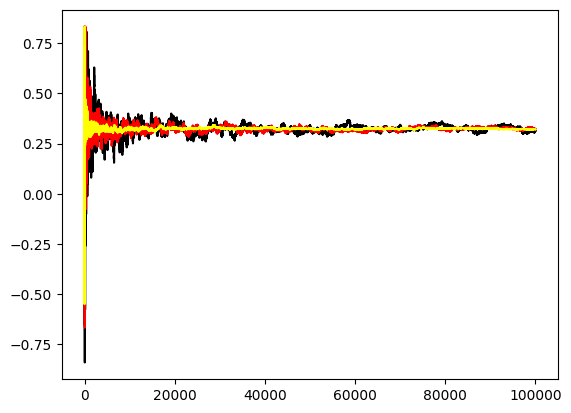

0.3146324723633734


In [ ]:
MAX=5
n=100000
beta=1
c=1

Lambda=1.5#(r+0.14163)/sigma_prim

def gamma(n):
    return c/(n+1)**beta

def Theta(n):
    return 1/np.sqrt(n)

def algorithme_rm(x_0,n,F,G):
    X=np.zeros(n)
    X[0]=x_0
    for i in range(0,n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i+1])
    return X


def algorithme_rm_chen(x_0,MAX,n,F,G):
    X=np.zeros(n);
    X[0] = x_0;
    for i in range(n-1):
        X[i+1]=X[i]-gamma(i)*F(X[i],G[i+1])
        if(abs(X[i+1]) >= MAX):
            X[i+1]=0
    return X




def F_BS(x,U):
    return np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K,0)-C_m


def F_BS_2(x,U):
    return np.exp(-U*Lambda-Lambda**2*0.5)*np.exp(-r*T)*max(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*(U+Lambda))-K,0)-C_m


def FP(x,g):
    u=0
    v=0
    if g<=d1(x):
        u=S_0
    else:
        u=0
    if g<=d2(x):
        v=K*np.exp(-r*T)
    else:
        v=0
    return u-v-C_m



G1=np.random.normal(size=n)
G2=np.random.normal(size=n)
G3=np.random.normal(size=n)

# G2=G1
# G3=G1

Y1=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,FP,G1)
Y2=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,F_BS,G2)
Y3=algorithme_rm_chen(sigma_prim,sigma_prim*2.6,n,F_BS_2,G3)

plt.plot(Y1,'black')
plt.plot(Y2,'red')
plt.plot(Y3,'yellow')


# plt.plot([sigma_prim for i in range(n)],'green')
plt.show()

sigma_prim=Y1[-1]
print(sigma_prim)

On a aussi avec

$$M_n=\frac{V_0+....+V_n}{n} \text{, $M_n$ converge présque surement vers } 0 $$

On a avec $\gamma_n=\frac{1}{n+1}$

$$M_{n+1} = M_n -\gamma_n \left(M_n - V_{n+1}\right)=M_n -\gamma_n \left(M_n - H(\sigma,G_{n+1})\right)= M_n -\gamma_n F \left(M_n , G_{n+1}\right)$$

En effet,

$$\begin{align*}
M_{n+1}-M_n&=\frac{n\sum_{i=1}^{n+1}V_i-(n+1)\sum_{i=1}^nV_i}{n(n+1)}&\\
\\
&=\frac{V_{n+1}}{n+1}-\frac{M_n}{n+1}&\\
\\
&=-\gamma_n(M_n-V_{n+1})\\
\\
&= -\gamma_n F \left(M_n , G_{n+1}\right)\\
\\
\end{align*}$$

<!-- Soit $f(x)=x-C$  et $x'$ tel que $f(x')=x'-C=0$ et $G$ une gaussienne centrée réduite, donc $\mathbb{E}[G]=0$ et $Var[G]=1$.



Finalement je trouve que,

$$f(x)=\mathbb{E}[F(x,G)]=x-C$$ -->


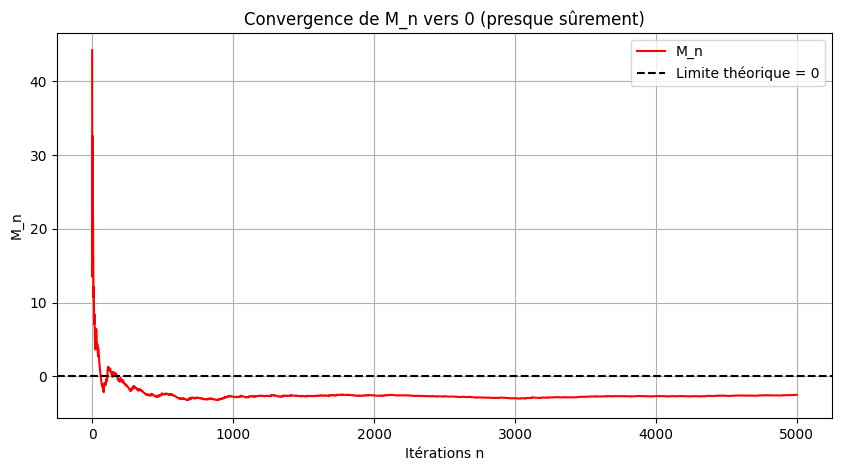

In [ ]:

S0 = S_0

sigma_true = sigma_prim
C = C_m


N = 5000
M_vals = []
M_n = 0.0

np.random.seed(0)

for n in range(1, N + 1):
    gamma_n = 1 / n

    # Génère G_n ~ N(0,1)
    G = np.random.randn()


    exponent = (r - 0.5 * sigma_true ** 2) * T + sigma_true * np.sqrt(T) * G
    ST = S0 * np.exp(exponent)


    payoff = np.exp(-r * T) * max(ST - K, 0)
    V_n = payoff - C


    M_n = M_n - gamma_n * (M_n - V_n)
    M_vals.append(M_n)


plt.figure(figsize=(10, 5))
plt.plot(M_vals,'red', label="M_n")
plt.axhline(0, color='black', linestyle='--', label="Limite théorique = 0")
plt.xlabel("Itérations n")
plt.ylabel("M_n")
plt.title("Convergence de M_n vers 0 (presque sûrement)")
plt.legend()
plt.grid(True)
plt.show()


# Optimisation du paramètre d'une fonction d'importance

On veut calculer $\mathbb{E}(f(G))$. Avec $\frac{d\mathbb{Q}}{d\mathbb{P}}=e^{-\lambda G - \frac{\lambda^2}{2}}$, on a,
$$\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda)\right\}= \mathbb{E}^{\mathbb{Q}}\left\{f(G+\lambda)\right\}=\mathbb{E}\left\{f(G)\right\}=C$$,


On cherche a minimiser en $\lambda$ la variance de ,
        $$X_\lambda = e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda)$$

***************
**Proposition :**
        $$Var\left\{X_\lambda\right\}= \mathbb{E}\left\{e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\} - \mathbb{E}{f(G)}^2$$,
***************
On a,
$$\begin{align*}
        Var\{X_{\lambda}\}&=\mathbb{E}\left\{(e^{-\lambda G - \frac{\lambda^2}{2}} f(G+\lambda))^2\right\}-\mathbb{E}\{f(G)\}^2\\
&=\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} g(G+\lambda)\right\}-\mathbb{E}\{f(G)\}^2\\
&=\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2
\end{align*}$$

Avec $g(x)=e^{-\lambda x+\frac{\lambda^2}{2}}f^2(x)$,

On traitera le cas du call dans le modèle de Black et Scholes avec les paramètres suivants\n",
        $r=r_{mkt}$, $\sigma=\sigma'/\mbox{an}$, $S_0=x=100$, $T=1$."

In [ ]:
from math import exp
import math
# r=0.02
sigma=sigma_prim
T=1
x=100
K=100
n=1000
N=1000
def f1(g):
    d=np.size(g);
    S_T=np.zeros(d);
    S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g);
    return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))));

def f(g):
    if(isinstance(g,float) or isinstance(g,int)):
        ST=0;
        ST=float( x * exp((r - sigma*sigma/2)*T+sigma*math.sqrt(T)*g));
        return(exp(-r*T)*max(ST-K,0))
    else:
        d=np.size(g)
        S_T=np.zeros(d)
        S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g)
        return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))))




def approx_variance(Lambda,G):
    # ATTENTION: G est un vecteur echantillon de gaussiennes
    return(np.mean(np.exp(-Lambda*G+0.5*Lambda**2)*f(G)**2)-(np.mean(f(G))**2))

U=np.random.normal(size=n)
approx_variance(1,U)

np.float64(55.03269438395816)

Nous allons voir maintenant quel est le $\lambda$ qui minimise la variance de $X_{\lambda}$

Soit $S_N=\frac{\sum_{n=0}^NVar\{X_{\lambda}\}_n}{N}$

On a alors,

$$S_{N+1}-S_N=\frac{\sum_{n=0}^{N+1}Var\{X_{\lambda}\}_n}{N+1}-\frac{\sum_{n=0}^NVar\{X_{\lambda}\}_n}{N}$$

donc,

$$S_{N+1}-S_N=\frac{NVar\{X_{\lambda}\}_{N+1}-\sum_{n=0}^NVar\{X_{\lambda}\}_n}{N(N+1)}=-\frac{1}{N+1}(S_N-Var\{X_{\lambda}\}_{N+1})$$

donc,

$$S_{N+1}=S_N-\frac{1}{N+1}(S_N-Var\{X_{\lambda}\}_{N+1})$$

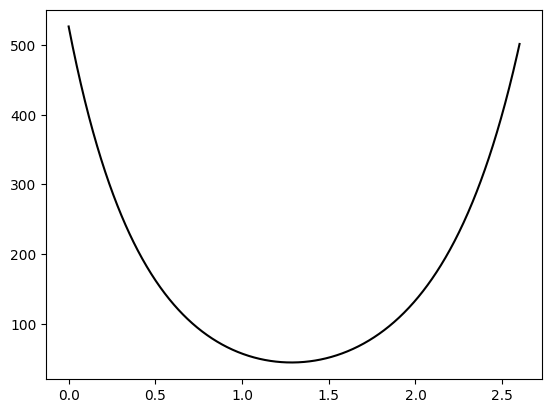

In [ ]:
Lambda = np.linspace(0,2.6,n)
z=np.zeros(np.size(Lambda));
U=np.random.normal(size=n);
mean=np.zeros(np.size(Lambda))
for j in range(500):
    U=np.random.normal(size=n);
    z=np.zeros(np.size(Lambda));
    for i in range(np.size(Lambda)):
        z[i]=approx_variance(Lambda[i],U)
        mean[i]=mean[i]-1/(j+1)*(mean[i]-z[i])
# plt.plot(Lambda,z,'red');
plt.plot(Lambda,mean,'black');

**Proposition :** *la dérivée peut s'écrire sous les deux formes suivantes*\n,
$$\frac{\partial}{\partial \lambda}Var\left(X_\lambda\right)
           =  \mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}
           =  - \mathbb{E}\left\{ G e^{-2\lambda G - \lambda^2} f^2(G+\lambda)\right\}$$
On a
$$\begin{align*}
\frac{\partial}{\partial \lambda}Var\left(X_\lambda\right)&= \frac{\partial}{\partial \lambda}\mathbb{E}\left\{e^{-\lambda G+\frac{\lambda^2}{2}}f^2(G)\right\}=\mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}
\end{align*}$$,

D'autre part, avec $h(x)=(\lambda - x)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(x)$,

$$\begin{align*},
\mathbb{E}\left\{(\lambda - G)e^{-\lambda G + \frac{\lambda^2}{2}} f^2(G)\right\}&= \mathbb{E}\left\{h(G)\right\}\\
&=\mathbb{E}\left\{e^{-\lambda G - \frac{\lambda^2}{2}} h(G+\lambda)\right\}\\
&= - \mathbb{E}\left\{ G e^{-2\lambda G - \lambda^2} f^2(G+\lambda)\right\}
\end{align*}$$

On vérifie ce fait par simulation en tracant les deux approximationsn Monte-Carlo de la dérivées.

On chercher à résoudre $\frac{\partial}{\partial \lambda}Var\left(X_\lambda \right)=0$ en utilisant la première représentation de la dérivée. \n",



Pour cela, on pose $X_0=0$, puis,
$$X_{n+1}=X_n-\gamma_n (X_n - G_{n+1})e^{-X_n G_{n+1} + \frac{X_n^2}{2}} f^2(G_{n+1})$$,
Ou bien,

$$X_{n+1}=X_n +\gamma_n G_{n+1} e^{-2X_n G_{n+1} - X_n^2} f^2(G_{n+1}+X_n)$$


On remarque alors que l'algorithme ne converge pas, $f$ n'est pas continue ?

On implémente cet algorithme en ramenant  $X_n$ une valeur initiale commune lorsque $X_n$ dépasse la valeur de  5  (procédure dite de *projection de Chen*). On peut voir que l'algorithme converge

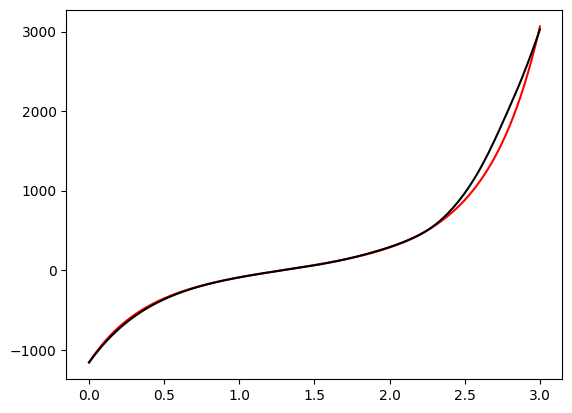

In [ ]:
def approx_1_derivee_variance(Lambda):
    #G=np.random.normal(size=2000)
    Y=(Lambda-G)*np.exp(-Lambda*G+Lambda**2*0.5)*f(G)**2
    return np.mean(Y)

def approx_2_derivee_variance(Lambda):
    #G=np.random.normal(size=2000)
    Y=-G*np.exp(-2*Lambda*G-Lambda**2)*f(G+Lambda)**2
    return np.mean(Y)


K=100;
Lambda=np.linspace(0,3,n)
z1=np.zeros(np.size(Lambda));
z2=np.zeros(np.size(Lambda));
G=np.random.normal(size=n);
mean=np.zeros(np.size(Lambda))
for i in range(np.size(Lambda)):
    z1[i]=approx_1_derivee_variance(Lambda[i]);
    z2[i]=approx_2_derivee_variance(Lambda[i]);
plt.plot(Lambda,z1,'red');
plt.plot(Lambda,z2,'black');

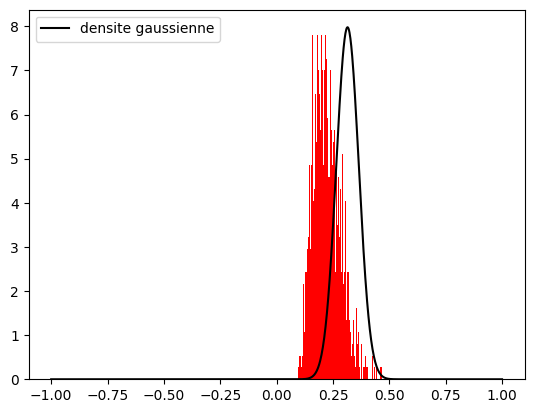

In [ ]:

z=np.zeros(1000);
for i in range(1000):
    U=np.random.normal(size=n);
    X=algorithme_rm_chen(0.1,MAX,n,F_BS,U)
    z[i]=X[-1]

# La densité gaussienne de référence
x = np.linspace(-1,1,1000)
densiteGaussienne = 1./(0.05*np.sqrt(2*np.pi))*np.exp(-0.5*((x-sigma_prim)/0.05)**2)
plt.plot(x, densiteGaussienne,color='black', label="densite gaussienne")
plt.legend(loc="best")

plt.hist(z, color="red", density="True", bins=100, label="erreur normalisee");

***********************
**Théorème:**(Loi des grands nombres pour les martingale)

Soit $(S_n)_{n\geq0}$ une martingale de carrée integrable, on a alors:

 +*Sur* $\langle S\rangle_\infty:=\lim_{n\rightarrow \infty}\langle S\rangle_n<\infty$ $S_n$ *converge présque surement vers une variable :$S_\infty$,

+*Sur* $\{\langle S\rangle_\infty=\infty\}$
          $$\lim_{n\rightarrow\infty}\frac{S_n}{\langle S\rangle_n}=0 \text{ , p.s}$$

En plus, si $a(t)$ est une fonction positive, croissante telle que

$\int_0^{\infty}\frac{dt}{1+a(t)}<\infty$,
alors,
       $$\lim_{n\rightarrow \infty}\frac{S_n}{\sqrt{a(\langle S\rangle_n)}}=0\text{ , p.s}$$
   
***********************   
**Preuve du théorème**
Soit la variable aléatoire

$$τ_p=\inf\Big\{n\geq0; \big<M\big>_{n+1}>p\Big\}$$
$τ_p$ est un temps d'arret car $\big<M\big>_{n}$ est prévisible, alors $M_{n∧\tau_p}^2-\big<M\big>_{n∧\tau_p}$ est aussi une martingale, on a aussi $M_{n∧\tau_p}\leq p$ et $M_{n∧\tau_p}^2=M_{n∧\tau_p}^2-\big<M\big>_{n∧\tau_p}+\big<M\big>_{n∧\tau_p}$ est integrable car $M_{n∧\tau_p}^2-\big<M\big>_{n∧\tau_p}$ est la martingale carrée qui est integrable et $\big<M\big>_{n∧\tau_p}$ est bornée
en plus $∀n\geq0$

$$\begin{align*}
\mathbb{E}\Big\{M_{n∧\tau_p}^2\Big\}&=\mathbb{E}\Big\{M_{0}^2-\big<M\big>_{0}\Big\}+\mathbb{E}\Big\{M_{n∧\tau_p}\Big\}
\\
&=\mathbb{E}\Big\{M_{0}^2\Big\}+\mathbb{E}\Big\{M_{n∧\tau_p}\Big\}
\\
&\leq\mathbb{E}\Big\{M_{0}^2\Big\}+p
\\
\end{align*}$$
donc $(M_{n∧\tau_p})_n$ est une martingale bornée dans $L^2$, alors elle converge quand $n→∞$ vers une variable $M_{∞}$. Comme c'est vrai pour n'importe quel $p$, $M_n→M_{∞}$ sur $\underset{p\geq 0}{⋃}\Big\{\tau_p=+∞\Big\}$. On a $\Big\{\big<M\big>_∞\leq p\Big\}=\Big\{\tau_p=+∞\Big\}$
donc

$$\Big\{\big<M\big>_∞<∞\Big\}=\underset{p\geq 0}{⋃}\Big\{\big<M\big>_∞\leq p\Big\}=\underset{p\geq 0}{⋃}\Big\{\tau_p=+∞\Big\}$$
Alors sur l'ensemble $\Big\{\big<M\big>_∞<∞\Big\}, $M_n$ converge vers $M_{∞}$ ce qui prouve le premiers point.

Pour le second, on considère le process

$$N_n=\sum_{k=1}^n\frac{M_k-M_{k-1}}{\sqrt{1+a(\big<M\big>_k)}}$$


$\sqrt{1+a(\big<M\big>_k)}\geq 1$ et $M_k-M_{k-1}$ est integrable, alors $N_n$ est integrable, et puisque $\big<M\big>$ est prévisible on a
$$\mathbb{E}\left\{\frac{M_k-M_{k-1}}{\sqrt{1+a(\big<M\big>_k)}} \mid\mathbb{F}_{k-1}\right\}=0$$

Donc $(N_n)_n$ est une martingale de carré intégrable et

$$\big<N\big>_{n+1}-\big<N\big>_{n}=\mathbb{E}\left\{\frac{(M_{n+1}-M_{n})^2}{1+a(\big<M\big>_{n+1})} \mid\mathbb{F}_{n}\right\}=\frac{\big<M\big>_{n+1}-\big<M\big>_{n+1}}{1+a(\big<M\big>_{n+1})}$$

Donc

$$\big<N\big>_{n}=\sum_{k=1}^n\frac{(M_{k+1}-M_{k})^2}{1+a(\big<M\big>_k)}\leq\sum_{k=1}^n∫^{\big<M\big>_{k}}_{\big<M\big>_{k-1}}\frac{dt}{1+a(t)}\leq∫^{+∞}_{0}\frac{dt}{1+a(t)}<∞$$

donc $\big<N\big>_{∞}<∞$ donc en utilisant le premier point $N_n$ converge vers une variable aléatoire $N_{∞}$.

En utilisant le lemme de Kronecker avec $ϵ_k=M_{k+1}-M_{k}$ et $A_k=\sqrt{1+a(\big<M\big>_k)}$ on obtient que

$$\lim_{n→∞}\frac{M_n-M_{0}}{\sqrt{1+a(\big<M\big>_n)}}=0= \lim_{n→∞}\frac{M_n}{\sqrt{a(\big<M\big>_n)}}$$

***********************

**Proposition:** Avec les même notations, on pose $S_0=0$ et $S_n=nM_n, \forall n >0$, alors $(S_n)_{n\geq0}$ est une martingale,et $\langle S\rangle_n=n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)$

***********************
On a

$$\begin{align*}
        \mathbb{E}\left\{S_{n+1}\mid\mathcal{F}_n\right\}&=\mathbb{E}\left\{V_1+...+V_V+V_{n+1}\mid\mathcal{F}_n\right\}\\
 &=V_1+...+V_n+0=S_n
 \end{align*}$$


Donc $(S_n)_{n\\geq0}$ est une martingale, en plus $\langle S\rangle_0=0$, et $\forall n>0$


Avec $g(x)=e^{-\lambda x+\frac{\lambda^2}{2}}f^2(x)$,

$$\langle S\rangle_{n+1}-\langle S\rangle_n=\mathbb{E}\left\{(S_{n+1}-S_n)^2\mid\mathcal{F}_n\right\}=Var\{V_{n+1}\}=\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2$$

Donc


$$\langle S\rangle_n=\sum_{k=0}^{n-1}\langle S\rangle_{k+1}-\langle S\rangle_k=n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)$$



Donc $\langle S\rangle_\infty=\infty$, et en utilisant le théorème précédant on retrouve la loi forte des grands nombre. \n",

On a alors
$$\lim_{n\rightarrow\infty}\frac{V_1+...+V_n}{n\left(\mathbb{E}\left\{g(G)\right\}-\mathbb{E}\{f(G)\}^2\right)}=0 \text{  p.s}$$


**Remarque:**   On utilise la fonction $a(t)=Ct^{2-\beta}$,  on trouve alors en faisant les changements de variables $k=2-\beta$ et dans l'integration $u=(C^{\frac{1}{k}}t)$ et $x=\frac{1}{1+u^k}$  que:,

$$\begin{align*}
\int_0^\infty\frac{dt}{1+a(t)}&=C^{\frac{-1}{k}}\int_0^\infty\frac{du}{1+u^k}\\
  &=\frac{C^{\frac{-1}{k}}}{k}\int_0^1x^{(1-\frac{1}{k})-1}(1-x)^{\frac{1}{k}-1}dx\\
  &=\frac{C^{\frac{-1}{k}}}{k}\beta\left(\frac{1}{k},1-\frac{1}{k}\right)<\infty
\end{align*}$$

On a alors avec $\gamma_n=\frac{C}{n^\beta}$,

$$\lim_{n\rightarrow\infty}\frac{S_n}{\sqrt{a(\langle S \rangle_n)}}=0 \text{ , p.s}$$",
        

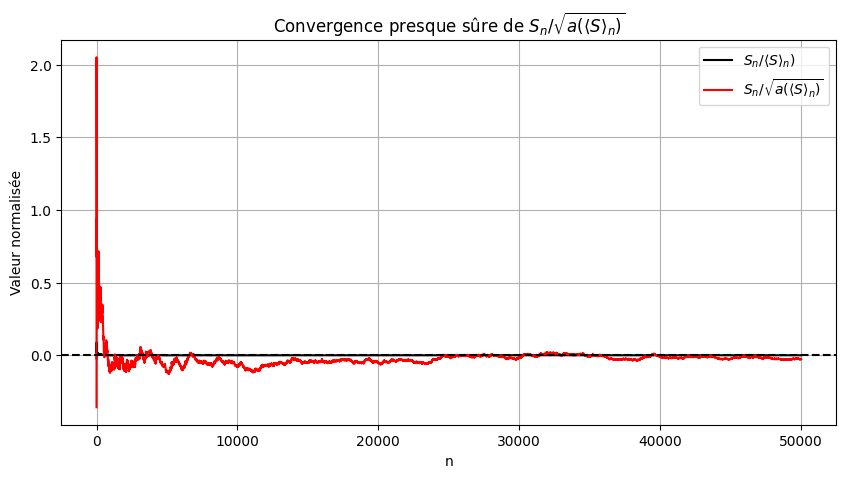

Intégrale ∫ dt / (1 + a(t)) = 12.8106 < ∞  → condition satisfaite


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_function




S0 = S_0

sigma = sigma_prim

N = 50000



# Simulation des G_i ~ N(0,1)
G = np.random.randn(N)

# Calcul des S_T^{(i)}
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * G)


def call_ferme(x,S_0):
    return S_0*norm.cdf(d1(x))-K*np.exp(-r*T)*norm.cdf(d2(x))


# Payoff et V_i
payoff = np.maximum(S_T - K, 0)
V = np.exp(-r * T) * payoff -call_ferme(sigma,S0) #- C


S_n = np.cumsum(V)
variance_V = np.var(V)  # constante : Var[V_i]
langle_S_n = np.arange(1, N+1) * variance_V  # <S>_n = n Var[V_i]

beta = .55
C_a = .10
k = 2 - beta


a_langle_S = C_a * langle_S_n ** k
normalized = S_n / np.sqrt(a_langle_S)

S_nLangleS=S_n/langle_S_n


plt.figure(figsize=(10, 5))

# G1=list(np.random.normal(size=N))
# G2=list(np.random.normal(size=N))
# Mn=[F_BS(sigma_prim,g)/u for g in G1]
# P=np.cumsum(Mn)/np.arange(1,N+1)
plt.plot(S_nLangleS,'black',label=r"$S_n / \langle S \rangle_n)$")
plt.plot(normalized,'red', label=r"$S_n / \sqrt{a(\langle S \rangle_n)}$")
plt.axhline(0, color='black', linestyle='--')
plt.title(r"Convergence presque sûre de $S_n / \sqrt{a(\langle S \rangle_n)}$")
plt.xlabel("n")
plt.ylabel("Valeur normalisée")
plt.grid(True)
plt.legend()
plt.show()

# Vérification de la condition d'intégrabilité
I = C_a**(-1/k) / k * beta_function(1/k, 1 - 1/k)
print(f"Intégrale ∫ dt / (1 + a(t)) = {I:.4f} < ∞  → condition satisfaite")



In [ ]:
sigma=sigma_prim
T=1
x=100
K=100
n=1000
N=1000
def f1(g):
    d=np.size(g);
    S_T=np.zeros(d);
    S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g);
    return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))));

def f(g):
    if(isinstance(g,float) or isinstance(g,int)):
        ST=0;
        ST=float( x * exp((r - sigma*sigma/2)*T+sigma*math.sqrt(T)*g));
        return(exp(-r*T)*max(ST-K,0))
    else:
        d=np.size(g)
        S_T=np.zeros(d)
        S_T= x * np.exp((r - sigma*sigma/2)*T*np.ones(d)+sigma*np.sqrt(T)*g)
        return(math.exp(-r*T)*np.maximum(S_T-K*np.ones(np.size(S_T)),np.zeros(np.size(S_T))))




def approx_variance(Lambda,G):

    return(np.mean(np.exp(-Lambda*G+0.5*Lambda**2)*f(G)**2)-(np.mean(f(G))**2))
U=np.random.normal(size=n)

u=approx_variance(4,U)
u

np.float64(31570.107519789166)

In [ ]:
[1,2,3,4,5,6][2:]

[3, 4, 5, 6]

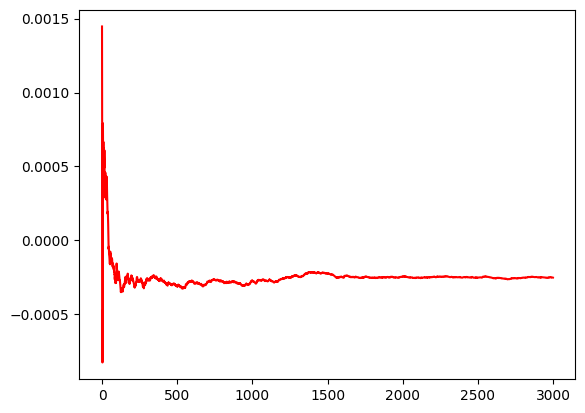

In [ ]:

N=3000
G1=list(np.random.normal(size=N))
G2=list(np.random.normal(size=N))
Mn=[F_BS(sigma_prim,g)/u for g in G1]
P=np.cumsum(Mn)/np.arange(1,N+1)
plt.plot(P,'red')


# Equation de la chaleur et pricing de Call Europeen

On suppose toujours que la dynamique d'une action A suit est la suivante

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

$$$$

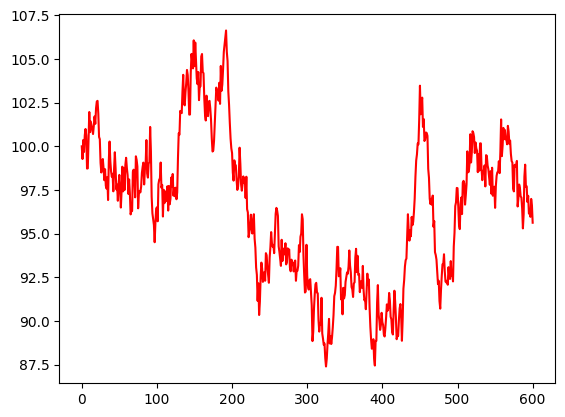

In [ ]:
dt=0.001
G=list(np.random.normal(0,1,size=600))
S=[S_0]

for i in range(0,len(G)):
    S.append(S[i]+S[i]*(r*dt+sigma_h*G[i]*1*dt**0.5))

plt.plot(S,'red')



soit maintenant la fonction:

$$u(t,S_t):=\mathbb{E}\big\{e^{-r(T-t)}f(S_T)\mid\mathbb{F}_t\big\}$$

et soit

$$Z_t:=e^{-rt}u(t,S_t)=\mathbb{E}\big\{e^{-rT}f(S_T)\mid\mathbb{F}_t\big\}$$

Alors $Z_t$ est une martingale, en effet on a pour $s\leq t$:

$$\mathbb{E}\big\{Z_t\mid\mathbb{F}_s\big\}=\mathbb{E}\big\{\mathbb{E}\big\{e^{-rT}f(S_T)\mid\mathbb{F}_t\big\}\mid\mathbb{F}_s\big\}=\mathbb{E}\big\{e^{-rT}f(S_T)\mid\mathbb{F}_s\big\}=Z_s$$

d'autre part on a d'apres le lemme d'Ito,

$$dZ_t=e^{-rt}\big\{\partial_tu+rS_t\partial_xu+\frac{1}{2}\sigma^2S^{2}_t\partial^{2}_xu-ru\big\}dt+e^{-rt}\sigma S_tdB_t$$

or $Z_t$ est une martingale, donc,
$$\partial_tu+rS_t\partial_xu+\frac{1}{2}\sigma^2S^{2}_t\partial^{2}_xu-ru=0$$

## discretisation avec différences finies
 soit une discretisation du temps et du prix :
 $$\begin{cases}
      t_0\leq t_1\leq ...\leq t_n \leq...\leq t_N=T\\
      0\leq 1\leq ...\leq j\leq...\leq 2K &
    \end{cases}$$

On aproxime la solution $u(t_n,j)$ avec la discretisation suivante


$$\begin{cases}
      \partial_tu =\frac{u^{t+1}_j-u^t_j}{dt} \\
      \partial_xu =\frac{u^t_{j+1}-u^t_{j-1}}{2dx}\\
      \partial^{2}_xu=\frac{u^t_{j+1}+u^t_j-2u^t_{j-1}}{dx^2}
\end{cases}$$
    
On remplace dans notre équation et on trouve

$$u^{t+1}_j=u^t_{j-1}\big(\frac{v_1c_1}{2}+v_2c_2\big)+u^t_j\big(1+v_1c_1+rdt\big)+u^t_{j+1}\big(\frac{v_1c_1}{2}-\frac{v_2c_2}{2}\big)$$

avec

$$\begin{cases}
      v_1=\frac{dt}{dx^2} \\
      v_2=\frac{dt}{dx}\\
      c_1=\sigma^2S^{2}\\
      c_2=rS
    \end{cases}$$

True


/tmp/ipython-input-32-1365026858.py:35: RuntimeWarning: overflow encountered in scalar multiply
  u[s_steps] = 2*u[s_steps-1] - u[s_steps-2]
/tmp/ipython-input-32-1365026858.py:31: RuntimeWarning: overflow encountered in scalar add
  u[j] = temp1*u_prev[j-1] + temp2*u_prev[j] + temp3*u_prev[j+1]
/tmp/ipython-input-32-1365026858.py:31: RuntimeWarning: overflow encountered in scalar multiply
  u[j] = temp1*u_prev[j-1] + temp2*u_prev[j] + temp3*u_prev[j+1]
/tmp/ipython-input-32-1365026858.py:35: RuntimeWarning: invalid value encountered in scalar subtract
  u[s_steps] = 2*u[s_steps-1] - u[s_steps-2]
/tmp/ipython-input-32-1365026858.py:55: RuntimeWarning: divide by zero encountered in log
  d1 = 1/(vol*sqrt(time_max))*log(s/strike) + (r + vol**2/2)*time_max


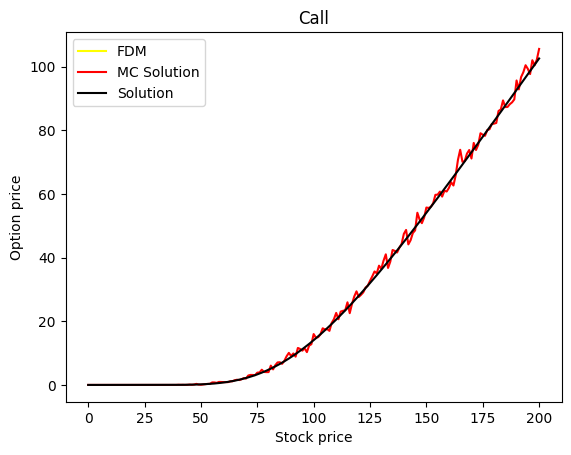

In [ ]:
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm




def fdm_call(vol, r, strike):

    print(dt <= 1/(vol**2*s_steps**2))

    spanS = [startS+s*ds for s in range(s_steps+1)]
    u = [max(s - strike, 0) for s in spanS]

    v1 = dt/ds**2
    v2 = dt/ds


    soln_grid = []
    for i in range(t_steps+1):
        u_prev = u
        for j in range(1, s_steps):
            coeff = vol**2*spanS[j]**2
            coeff1 = r*spanS[j]

            temp1 = v1*coeff/2 + v2*coeff1
            temp2 = 1 + v1*coeff + dt*r
            temp3 = v1*coeff/2 - v2*coeff1/2

            u[j] = temp1*u_prev[j-1] + temp2*u_prev[j] + temp3*u_prev[j+1]


        u[0] = 0
        u[s_steps] = 2*u[s_steps-1] - u[s_steps-2]

        soln_grid.append(array(u))




    def F_BS(x,U,S_0):
      if S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K>0:
        return np.exp(-r*T)*(S_0*np.exp((r-0.5*x**2)*T+x*np.sqrt(T)*U)-K)
      else:
        return 0

    MC_sol=[]
    bs_soln = []

    for s in spanS:
        G=np.random.normal(size=600)
        MC_sol.append(np.mean([F_BS(sigma_prim,g,s) for g in G]))

        d1 = 1/(vol*sqrt(time_max))*log(s/strike) + (r + vol**2/2)*time_max
        d2 = d1-vol*sqrt(time_max)
        val = norm.cdf(d1)*s-norm.cdf(d2)*strike*exp(-r*time_max)
        bs_soln.append(val)

    return spanS, soln_grid, bs_soln, MC_sol




def graphs(spanS,soln_grid,bs_soln,mc_sol,option):
    final_soln = soln_grid[len(soln_grid)-1]
    plt.plot(spanS, final_soln,'yellow', label = 'FDM')
    plt.plot(spanS, mc_sol,'red', label = 'MC Solution')
    plt.plot(spanS, bs_soln,'black', label = 'Solution')

    plt.plot()
    plt.legend(loc=2)
    plt.xlabel("Stock price")
    plt.ylabel("Option price")
    plt.title(option)




vol = sigma_prim

strike = K


time_max = 1
dt = .0001

startS = 0
endS = 2 * strike
ds = 1

s_steps = int((endS-startS)/ds)

t_steps = int(time_max/dt)


spanS, soln_grid_C, bs_soln_C, MC_sol = fdm_call(vol,r,strike)
graphs(spanS,soln_grid_C,bs_soln_C,MC_sol,"Call")


# Systeme de particules

Soit

$$X_t=log(St)$$


Alors,

$$dX_t=\mu dt+\sigma dB_t$$

On definit alors la suite

$$X_{k+1}=X_k+\mu dt +Y_k \text{ou , }Y_k \sim N(0,\sigma^2 d t)$$

On veut estimer la probalilité:

$$p=\mathbb{P}\big(X_T> x\big) \text{, avec,  } x=log(K)$$
**************
**Theorem de Radon-Nikodym**

Soient $(\Omega, \mathbb{F}, \mu)$ un espace mesuré $\sigma$ fini et $\eta$ une mesure sur $(\Omega, \mathbb{F})$
Si $\eta$ absolument continue par rapport à $\mu$, alors si il existe une fonction $f\in L^1(\mu)$ telle que

$$\eta (A)=\int_A f d\mu$$

La fonction $f\in L^1(\mu)$ est appeleé dérivé de Radon Nikodym et

$$f=\frac{d\eta}{d\mu}$$

*****************

**Preuve**


On veut montrer qu'il existe une fonction  $f\in L^1(\mu)$ telle que

$$∀ A\in \mathbb{F}, ∫_Afd\mu=\eta (A)$$
Definisons l'operateur $T$ sur $L^{∞}(\mu)$
$$\forall \phi\in L^{∞}(\mu), T(\phi)=∫_X\phi d\eta$$

Alors
+ $T$ est bien defini car $\phi$ est borné et $\eta$ est une mesure finie
+ $T$ est un operateur positif
+ $T$ est continu car $\mid T(\phi)\mid=\mid∫_X\phi d\eta\mid\leq\mid\mid\phi\mid\mid_{∞}\eta(X)$

Le Theoreme de representation de Riesz pour l'espace $L^{∞}(\mu)$ affirme que tout operateur continue positif sur $L^{∞}(\mu)$ est donné par l'integration contre une fonction;

 $$∃f\in L^1(\mu)\text{ telle que }∀\phi\in L^{∞}(\mu), T(\phi)=∫_Xf\phi d\mu$$

 en prenant $\phi=\mathbb{1}_A$ on trouve que
 $$∫_Afd\mu=\eta (A)$$

maintenant, pour l'unicité de $f$, on suppose $f_1, f_2$ telles que

$$\eta (A)=∫_Af_1d\mu=∫_Af_2d\mu$$

donc,

$$0=∫_A(f_1-f_2)d\mu$$

Donc $f$ est unique $\mu$ $P.P$


**********************
**Theorem de Riesz**

Soit $ (X,\mathbb{F},\mu)$ un espace mesuré avec $\mu$ une mesure positive.
Soit

$$T: L^{∞}(\mu)→\mathbb{R}$$
Un fonctionel lineaire, continue et positif

Alors, il existe une fonction $f\in  L^{1}(\mu)$, $f\geq0$

presque partouttelle que:

$$∀\phi\in  L^{∞}(\mu), T(\phi)=∫_Xf\phi d\mu$$
****************
**Preuve**



**A : Construction des partition $P_n=\{A^{(n)}_j\}_{j=0}^{N^n}$ tels que**

+ Chaque $A^{(n)}_j$ est reunion d'elements de $P_{n+1}$
+  On suppose que $𝑼_{n}P_n$ engendre la tribu $\mathbb{F}$

+ sur chaque partition $A^{(n)}_j$ on definit :

$$f_n(x)=\frac{T(\mathbb{1}_{A^{(n)}_j})}{\mu(A^{(n)}_j)} \text{, si }x\in A^{(n)}_j$$

**B : Propriétés de la suite $(f_n)_n$**

 chaque $f_n$ est une fonction simple mesurable, constante sur chaque $A^{(n)}_j$

Par positivité de $T$ on a,

$$f_n(x)\geq 0,   \text{ $\mu$ P.P}$$

On a aussi

$$\begin{align*}
\mid\mid f_n\mid\mid_{L^{∞}(\mu)}&=\sum_jf_n(x_j)\mu(A^{(n)}_j)\\
  &=\sum_jT(\mathbb{1}_{A^{(n)}_j})\\
  &=T\Big(\sum_j\mathbb{1}_{A^{(n)}_j}\Big)\\
  &=T(1)<\infty
\end{align*}$$

**$f_n$ est une martingale, Montrons que**
$$\mathbb{E}\Big\{f_{n+1}\mid \mathbb{F}_n\Big\}(x)=f_n(x)$$

Soit $x\in A^{(n)}_j$, On a

$$f_n(x)=\frac{T(\mathbb{1}_{A^{(n)}_j})}{\mu(A^{(n)}_j)}$$

Or,
$$A^{(n)}_j=\bigcup_{k\in I_j}A^{(n+1)}_k$$

 Ou $I_j$ l'ensemble des indice $k$ tels que $A^{(n+1)}_k\subset A^{(n)}_j $, et on a

 $$T(\mathbb{1}_{A^{(n)}_j})=\sum_{k\in I_j}T(\mathbb{1}_{A^{(n+1)}_k})$$

Donc,

$$f_n(x)=\frac{\sum_{k\in I_j}T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n)}_j)}=\sum_{k\in I_j}w_kf_{n+1}(x_k)$$

On a aussi pour $x\in A^{(n+1)}_k\subset A^{(n)}_j $

$$f_{n+1}(x)=\frac{T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n+1)}_k)}$$

On a ,

$$\mathbb{E}\Big\{f_{n+1}\mid \mathbb{F}_n\Big\}(x)=\frac{1}{\mu(A^{(n)}_j)}∫_{A^{(n)}_j}f_{n+1}(y)d\mu(y)$$

Or, $f_n$ est constante sur chaque $A^{(n+1)}_k$, donc

$$\begin{align*}
∫_{A^{(n)}_j}f_{n+1}(y)d\mu(y)&=\sum_{k\in I_j}∫_{A^{(n+1)}_k}f_{n+1}(y)d\mu(y)\\
&=\sum_{k\in I_j}f_{n+1}(x_k)\mu(A^{(n+1)}_k)
\end{align*}$$

Don,

$$\begin{align*}
\mathbb{E}\Big\{f_{n+1}\mid \mathbb{F}_n\Big\}(x)&=\frac{\sum_{k\in I_j}\frac{T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n+1)}_k)}\mu(A^{(n+1)}_k)}{\mu(A^{(n)}_j)}\\
&=\frac{\sum_{k\in I_j}T(\mathbb{1}_{A^{(n+1)}_k})}{\mu(A^{(n)}_j)}\\
&=\frac{T(\mathbb{1}_{A^{(n)}_j})}{\mu(A^{(n)}_j)}\\
&=f_n(x)
\end{align*}$$

**Convergence p.p et $L^{1}(\mu)$**

avec le theoreme de convergence des martingales, la suite $f_n$ converge vers une fonction $f\in L^{1}(\mu)$

**Representation de $T$**

Pour toute fonction simple $\phi$ mesurable

$$\begin{align*}
T(\phi)&=\sum_j \phi(x_j)T(\mathbb{1}_{A^{(n)}_j})\\
&=\sum_j \phi(x_j)f_n(x_j)\mu(A^{(n)}_j)\\
&=\int_Xf_n\phi d\mu
\end{align*}$$
Par passage à la limite, on trouve que
$$T(\phi)=\int_Xf\phi d\mu$$
enfin par densité des fonctions simple dans $L^{∞}(\mu)$ on trouve que

$$∀\phi\in L^{∞}(\mu) , T(\phi)=\int_Xf\phi d\mu$$
*********
Dans notre cas on définit

**la mesure $\mathbb{P}$** La mesure sous laquelle

$$X_t=log(S_t), \text{ suit la dynamique suivante } dX_t = \mu dt+\sigma dB_t$$


**la mesure $\mathbb{Q}^\theta$** La mesure sous laquelle le precessus suit la dynamique

$$dX_t = (\mu-\sigma\theta)dt+\sigma dB_t$$



avec

$$\theta=\frac{x-log(S_0)-\mu T}{\sigma \sqrt{T}}$$

D'apres le theoreme de girsanov, la dérivé de Radon Nikodym est :

$$L_T=\frac{d\mathbb{Q}^\theta}{d\mathbb{P}}=exp\Big\{-\theta\int_0^TdB_s-\frac{1}{2}\theta^2T\Big\}$$

en utilisant la propriéte d'Ito, on trouve que $\int_0^TdB_s=B_T$, donc


$$L_T=exp\Big\{-\theta B_T-\frac{1}{2}\theta^2T\Big\}$$

et

$$B_T=\frac{X_T-X_0-\mu T}{\sigma}=\frac{Y_T}{\sigma}$$

donc

$$L_T=exp\Big\{-\theta \frac{X_T-X_0-\mu T}{\sigma}-\frac{1}{2}\theta^2T\Big\}=exp\Big\{-\frac{\theta}{\sigma} Y_T-\frac{1}{2}\theta^2T\Big\}$$

En utilisant le théorème de Raddon Nikodym on trouve que

$$I=\mathbb{E}^{\mathbb{P}}\Big\{\mathbb{1}_{\{X_T>x\}}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T} \mathbb{1}_{\{X_T>x\}}\Big\}$$



et

$$\frac{1}{L_T}=exp\Big\{\theta \frac{X_T-X_0-\mu T}{\sigma}+\frac{1}{2}\theta^2T\Big\}=exp\Big\{\frac{\theta}{\sigma} Y_T+\frac{1}{2}\theta^2T\Big\}$$


$\frac{1}{L_T}$ est bornée en moyenne:

$$\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{d\mathbb{P}}{d\mathbb{Q}^{\theta}}\Big\}=1$$



$$I=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T} \mathbb{1}_{\{X_T>x\}}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{exp\Big\{\frac{\theta Y}{\sigma}+\frac{1}{2}\theta^2T\Big\} \mathbb{1}_{\{X_T>x\}}\Big\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{exp\{\frac{\theta Y}{\sigma}\} \mathbb{1}_{\{X_T>x\}}\Big\}exp\{\frac{1}{2}\theta^2T\}$$

## Convergence Monte Carlo



$$\prod^{n-1}_{k=0}\frac{1}{M}\sum_{j=1}^Mexp\big\{\frac{\theta}{\sigma}Y_k^{(j)}\big\}$$

$$\text{ converge preseque surement vers, } exp\{\frac{1}{2}\theta^2T\}\text { quand } n,M\rightarrow \infty$$

d'une autre part,

$$\prod^{n-1}_{k=0}\frac{1}{M}\sum_{j=1}^Mexp\big\{\frac{\theta}{\sigma} Y_k^{(j)}\big\}\frac{1}{M}\sum_{j=1}^M\mathbb{1}_{\{X_n^{(j)}>x\}}exp(\frac{\theta}{\sigma} Y_n)$$

$$\text{ converge preseque surement vers, } I=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{exp\{\frac{\theta Y}{\sigma}\} \mathbb{1}_{\{X_T>x\}}\Big\}exp\{\frac{1}{2}\theta^2T\}=\mathbb{E}^{\mathbb{Q}^{\theta}}\Big\{\frac{1}{L_T} \mathbb{1}_{\{X_T>x\}}\Big\}\text { quand } n,M\rightarrow \infty$$


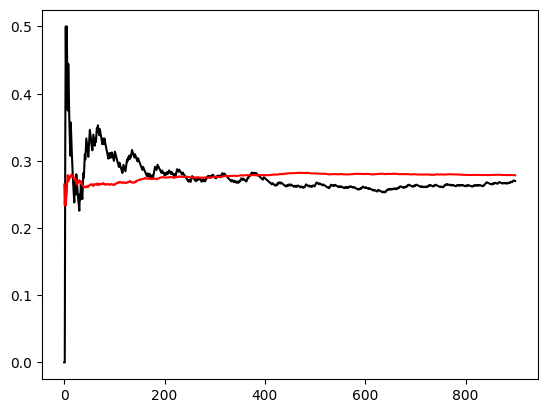

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

K=K
S_0=S_0
sigma=sigma_prim
r=r
T=1
# temps
n=90
st=T/n

dt=1/n
# nb particule
M=60

#nb simulation
N=900

x=np.log(K)

mu=r-0.5*sigma**2

theta=(x - np.log(S_0) - mu*T)/(sigma*np.sqrt(T))



means=[]
cumul_sum=0

for i in range(1,N+1):
    #Y=np.random.normal(0,1,M)*(sigma*np.sqrt(dt))
    #X=np.log(S_0)+mu*dt+Y
    X=np.full(M,np.log(S_0))
    norm=1

    #temps
    for k in range(1,n):

        Y=np.random.normal(0,sigma*np.sqrt(dt),M)

        X+=mu*dt+Y



        G=np.exp(theta/sigma*Y)
        norm*=np.mean(G)

        w=G/np.sum(G)
        cdf=np.cumsum(w)
        u0=np.random.uniform(0,1/M)
        u=u0+np.arange(M)/M
        ind=np.searchsorted(cdf,u)
        X=X[ind]

    Y_final=X-np.log(S_0)-mu*T
    weightsFinal=np.exp(theta/sigma*Y_final)
    indicators=(X>x).astype(float)
    estimate=norm*np.mean(indicators*weightsFinal)

    cumul_sum+=estimate
    means.append(cumul_sum/i)




X_T=np.log(S_0)+mu*T+sigma*np.sqrt(T)*np.random.randn(N)

indicators=(X_T>np.log(K)).astype(float)

pEstimate=np.mean(indicators)

MeansNaive=np.cumsum(indicators)/np.arange(1,N+1)
MeanNaive=np.mean(indicators)
plt.plot(MeansNaive,'black')
plt.plot(means,'red')
# plt.plot([MeanNaive for _ in range(len(indicators))],)




# Temps local

**********
**Définition**

On définit le temps local en un point $a$ du brownien de la maniere suivante :
$$L_T^a = \lim_{ε→0} \frac{1}{2ε} ∫_0^T 1_{|B_s - a| ≤ ε} ds$$
*********

## Temps local en physique

On définit

$$M_t=e^{-\lambda L_t^a}$$

et

$$\tilde{M}_t=u(t,B_t)M_t$$

avec

$$u(t,x)=\mathbb{E}_x\big\{e^{-\lambda L_{T-t}^a}\big\}$$

On a avec Ito

$$d\tilde{M}_t=e^{-\lambda L_t^a}du(t,B_t)+u(t,B_t)d(e^{-\lambda L_t^a})+d⟨u(t,B_t),e^{-\lambda L_t^a}⟩$$

On utilise Ito pour $u(t,B_t)$ et on trouve que

$$du(t,B_t)=∂_tu(t,B_t)dt+∂_xu(t,B_t)dB_t+\frac{1}{2}∂_{xx}u(t,B_t)dt$$

Avec Ito-Tanaka on a

$$d(e^{-\lambda L_t^a})=-λe^{-\lambda L_t^a}dL_t^a$$

Et le terme de covariation est nul car $L_t^a$ est de variation finie

Donc

$$d\tilde{M}_t=e^{-\lambda L_t^a}\Big(∂_tu(t,B_t)+\frac{1}{2}∂_{xx}u(t,B_t)\Big)dt+e^{-\lambda L_t^a}dB_t-λu(t,B_t)e^{-\lambda L_t^a}dL_t^a$$

Le temps local satisfait l'équation suivante

$$\int_0^tf(B_s)ds=\int_{\mathbb{R}}f(x)L_t^xdx$$

Si on prend $f(x)=δ(x-a)$, on trouve que
$$\int_0^t\delta(B_s-a)ds=L_t^a$$
Donc
$$\delta(B_t-a)dt=dL_t^a$$
Donc on trouve que

$$d\tilde{M}_t=e^{-\lambda L_t^a}\Big(∂_tu(t,B_t)+\frac{1}{2}∂_{xx}u(t,B_t)-λu(t,B_t)δ(B_t-a)\Big)dt+e^{-\lambda L_t^a}dB_t$$

Prouvons maintenant que $(\tilde{M}_t)$ est une martingale, on veur prouver que,

$$\mathbb{E}\big\{\tilde{M}_{t+s}\mid\mathbb{F}_t\big\}=\tilde{M}_{t}$$

On a

$$L_T^a=L_t^a+L_T^a-L_t^a \text{ et } L_T^a-L_t^a \text{ suit la meme loi que }L_{T-t}^a$$

On a aussi

$$\mathbb{E}\big\{\tilde{M}_{t+s}\mid\mathbb{F}_t\big\}=\mathbb{E}\big\{u(t+s,B_{t+s})e^{-λL_{t+s}^a}\mid\mathbb{F}_t\big\}$$

De plus,

$$e^{-λL_{t+s}}=e^{-λL_{t}^a}e^{-λ(L_{t+s}^a-L_t^a)}$$
Donc,

$$\mathbb{E}\big\{\tilde{M}_{t+s}\mid\mathbb{F}_t\big\}=e^{-λL_{t}^a}\mathbb{E}\big\{u(t+s,B_{t+s})e^{-λ(L_{t+s}^a-L_t^a)}\mid\mathbb{F}_t\big\}$$

Par la propriété de Markov du Brownien et du temps local on trouve que,

$$\mathbb{E}\big\{u(t+s,B_{t+s})e^{-λ(L_{t+s}^a-L_t^a)}\mid\mathbb{F}_t\big\}=\mathbb{E}_{B_t}\big\{u(t+s,B_{s})e^{-λL_{s}^a}\mid\mathbb{F}_t\big\}$$

On a alors,

$$\begin{align}
\mathbb{E}_{B_t}\big\{u(t+s,B_{s})e^{-λL_{s}^a}\mid\mathbb{F}_t\big\}&=\mathbb{E}_{B_t}\Big\{\mathbb{E}_{B_s}\big\{e^{-λL_{T-t-s}^a}\big\}e^{-λL_{s}^a}\mid\mathbb{F}_t\Big\}\\
&=\mathbb{E}_{B_t}\Big\{\mathbb{E}_{B_s}\big\{e^{-λL_{T-t-s}^a}e^{-λL_{s}^a}\mid B_s\big\}\mid\mathbb{F}_t\Big\}\\
&=\mathbb{E}_{B_t}\Big\{e^{-λL_{T-t}^a}\mid\mathbb{F}_t\Big\}\\
&=\mathbb{E}_{B_t}\Big\{e^{-λL_{T-t}^a}\Big\}\\
&=u(t,B_t)
\end{align}$$
On trouve finalement que
$$\mathbb{E}\big\{\tilde{M}_{t+s}\mid\mathbb{F}_t\big\}=e^{-λL_{t}^a}u(t,B_t)=\tilde{M}_{t}$$

Puisque $(\tilde{M}_t)$ est une martingale, son drift est nul, donc $u$ satisfait l'EDP suivante,
$$∂_tu+\frac{1}{2}∂_{xx}u-λuδ(x-a)=0, \text{ et } u(.,T)=1$$

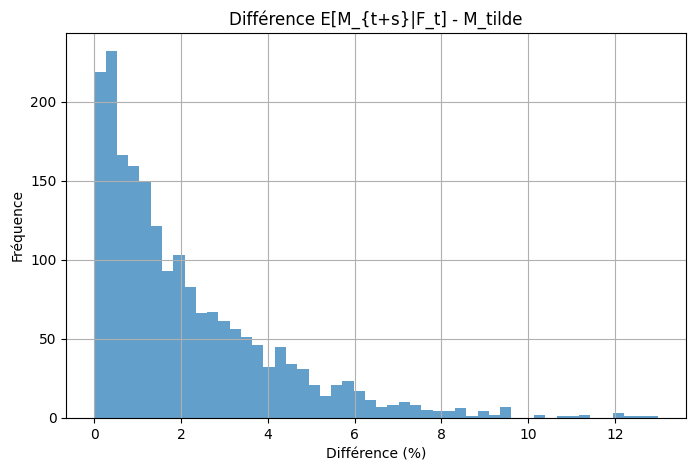

Moyenne de la différence : 2.1022564604479483
Écart-type de la différence : 2.017217550214226


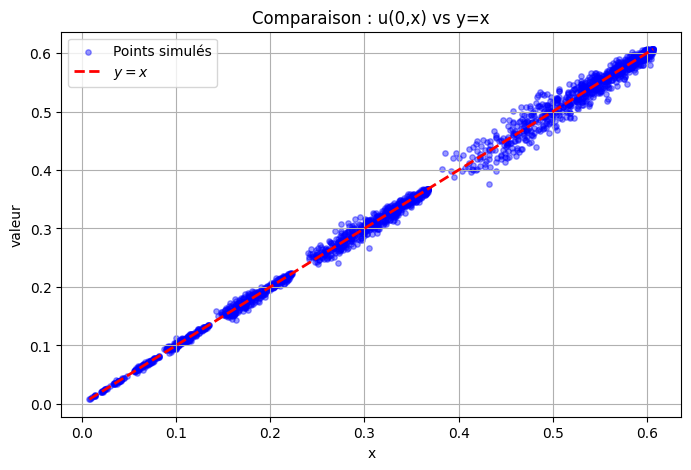

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Paramètres
# -----------------------------
T = 1.0
n = 1000
dt = T / n
N_traj = 2000       # nombre de trajectoires principales
N_cond = 200        # trajectoires conditionnelles pour l'espérance conditionnelle
a = 0.0
lam = 1.0
eps = 1e-3

# Fonction approximation du temps local
def approx_local_time_path(path, eps, dt, a):
    hits = np.abs(path[:-1] - a) < eps
    return np.sum(hits) * dt / (2.0 * eps)

# Fonction u(t,x) vectorisée (approx par Monte Carlo)
def u_vec(x, t, T, N_cond, n_cond):
    dt_cond = (T-t)/n_cond
    x = np.atleast_1d(x)
    res = np.zeros_like(x, dtype=float)
    for i, xi in enumerate(x):
        increments = np.random.normal(scale=np.sqrt(dt_cond), size=(N_cond, n_cond))
        B_cond = xi + np.cumsum(increments, axis=1)
        L_cond = np.sum(np.abs(B_cond - a) < eps, axis=1) * dt_cond / (2*eps)
        res[i] = np.mean(np.exp(-lam*L_cond))
    return res

# -----------------------------
# Simulation principale
# -----------------------------
rng = np.random.default_rng(2025)

# Générer toutes les trajectoires principales
increments = rng.normal(scale=np.sqrt(dt), size=(N_traj, n))
B_paths = np.cumsum(increments, axis=1)
B_paths = np.hstack((np.zeros((N_traj,1)), B_paths))  # B_0=0

# Choix du temps t pour vérifier la martingale
t_idx = n//2
s_idx = n - t_idx
t = t_idx * dt

# Calcul de L_t et M_tilde
L_t = np.sum(np.abs(B_paths[:,:t_idx+1] - a) < eps, axis=1) * dt / (2*eps)
B_t = B_paths[:,t_idx]
M_t = np.exp(-lam*L_t) * u_vec(B_t, t, T, N_cond, s_idx)

# Approximation de E[M_{t+s} | F_t] par trajectoires conditionnelles
E_M_cond = np.zeros(N_traj)
dt_cond = (T-t)/s_idx
for i in range(N_traj):
    increments_cond = rng.normal(scale=np.sqrt(dt_cond), size=(N_cond, s_idx))
    B_cond = B_t[i] + np.cumsum(increments_cond, axis=1)
    L_cond = np.sum(np.abs(B_cond - a) < eps, axis=1) * dt_cond / (2*eps)
    E_M_cond[i] = np.mean(np.exp(-lam*L_cond) * np.exp(-lam*L_t[i]))  # factorisation

# Différence
diff = abs(E_M_cond - M_t)/abs(M_t)*100

# -----------------------------
# Affichage 1 : Histogramme des différences
# -----------------------------
plt.figure(figsize=(8,5))
plt.hist(diff, bins=50, alpha=0.7)
plt.title("Différence E[M_{t+s}|F_t] - M_tilde")
plt.xlabel("Différence (%)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

print("Moyenne de la différence :", np.mean(diff))
print("Écart-type de la différence :", np.std(diff))

# -----------------------------
# Affichage 2 : Comparaison u(t,x) vs y=x
# -----------------------------
x_vals = np.linspace(min(M_t), max(M_t), 50)
u_vals = u_vec(min(M_t), max(M_t), T, N_cond, n)   # on prend t=0 pour avoir u(0,x)
y_vals = x_vals  # référence

plt.figure(figsize=(8,5))
#plt.plot(E_M_cond, M_t, label="u(0,x) estimé (Monte Carlo)", lw=2)
plt.scatter(M_t, E_M_cond, alpha=0.4, s=15, c="blue", label="Points simulés")

# tracer y = x
m_min, m_max = min(M_t.min(), E_M_cond.min()), max(M_t.max(), E_M_cond.max())
plt.plot([m_min, m_max], [m_min, m_max], 'r--', lw=2, label=r"$y = x$")
plt.xlabel("x")
plt.ylabel("valeur")
plt.title("Comparaison : u(0,x) vs y=x")
plt.legend()
plt.grid(True)
plt.show()


Paramètres: T=1.0, a=2.0, λ=2.0
Grille: dx=0.0805, dt=0.0010
Résolution de l'EDP...
Calcul par Monte Carlo...
Démarrage simulation Monte Carlo...
Progression: 0/150 points
Progression: 50/150 points
Progression: 100/150 points
Simulation Monte Carlo terminée.
Calcul par principe de réflexion...


/tmp/ipython-input-2184640732.py:166: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_zoom, u_pde_zoom, 'b-', color='black', label='EDP')


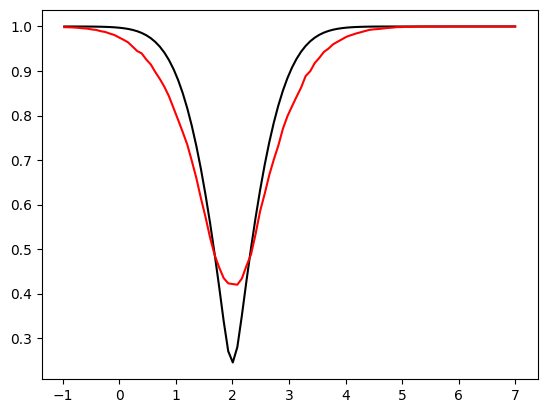

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------------
# Paramètres du problème
# -----------------------------
T = 1.0          # Temps final
a = 2.0          # Point où on mesure le temps local
lam = 2.0        # Paramètre lambda

# Grille spatiale
x_min, x_max = -5.0, 7
Nx = 150
x_grid = np.linspace(x_min, x_max, Nx)
dx = x_grid[1] - x_grid[0]

# Grille temporelle pour EDP
Nt = 1000
dt = T / Nt
t_grid = np.linspace(0, T, Nt+1)

print(f"Paramètres: T={T}, a={a}, λ={lam}")
print(f"Grille: dx={dx:.4f}, dt={dt:.4f}")

# -----------------------------
# Solution analytique exacte (pour validation)
# -----------------------------
def analytical_solution(t, x, T, a, lam):
    """
    Solution analytique pour E[exp(-λL_{T-t}^a)]
    où L_s^a est le temps local en a jusqu'au temps s
    """
    tau = T - t
    if tau <= 0:
        return np.ones_like(x)

    # Pour un mouvement brownien, la densité du temps local suit une loi connue
    # E[exp(-λL_τ^a)] = exp(-√(2λ) * |x-a|) / cosh(√(2λ) * √τ) pour certains cas
    # Ici on utilise une approximation basée sur la théorie des temps locaux

    sqrt_2lam = np.sqrt(2 * lam)
    result = np.exp(-sqrt_2lam * np.abs(x - a))

    return result

# -----------------------------
# Schéma EDP (Feynman-Kac) - Méthode implicite stable
# -----------------------------
def solve_pde_feynman_kac():
    """
    Résout l'EDP: ∂u/∂t + (1/2)∂²u/∂x² - λδ(x-a)u = 0
    avec condition finale u(T,x) = 1
    """
    # Initialisation avec condition finale
    u = np.ones(Nx)

    # Coefficient de diffusion
    alpha = dt / (2 * dx**2)

    # Approximation de la fonction delta de Dirac
    sigma_delta = dx  # largeur de l'approximation gaussienne
    delta_approx = (1/np.sqrt(2*np.pi*sigma_delta**2)) * np.exp(-0.5*((x_grid-a)/sigma_delta)**2)

    # Schéma semi-implicite pour la stabilité
    # Matrice tridiagonale pour la partie diffusion
    main_diag = 1 + alpha + dt * lam * delta_approx
    off_diag = -alpha/2 * np.ones(Nx-1)

    # Construction de la matrice A pour Au^{n+1} = u^n
    A = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)

    # Conditions aux bords (Neumann)
    A[0, 1] = -alpha
    A[-1, -2] = -alpha

    u_history = [u.copy()]

    # Boucle temporelle (rétrograde)
    for n in range(Nt):
        # Résolution du système linéaire
        u_new = np.linalg.solve(A, u)
        u = u_new.copy()

        # Enregistrement périodique
        if n % (Nt//10) == 0 or n == Nt-1:
            u_history.append(u.copy())

    return u, u_history

# -----------------------------
# Simulation Monte Carlo améliorée
# -----------------------------
def monte_carlo_simulation(N_paths=10000):
    """
    Calcule E[exp(-λL_{T-t}^a)] par simulation Monte Carlo
    """
    print("Démarrage simulation Monte Carlo...")

    u_mc = np.zeros(Nx)
    rng = np.random.default_rng(42)

    # Nombre de pas de temps pour la discrétisation des trajectoires
    N_steps = 1000
    dt_mc = T / N_steps
    sqrt_dt = np.sqrt(dt_mc)

    for ix, x0 in enumerate(x_grid):
        if ix % 50 == 0:
            print(f"Progression: {ix}/{Nx} points")

        payoffs = []

        for path in range(N_paths):
            # Simulation d'une trajectoire brownienne
            X = np.zeros(N_steps + 1)
            X[0] = x0

            # Génération de la trajectoire
            increments = rng.normal(0, sqrt_dt, N_steps)
            X[1:] = x0 + np.cumsum(increments)

            # Calcul du temps local en 'a' par approximation
            # L_t^a ≈ ∫_0^t δ(X_s - a) ds ≈ Σ 1_{|X_i - a| < ε} * dt
            epsilon = 5* dx  # largeur pour l'approximation
            local_time = np.sum(np.abs(X - a) < epsilon) * dt_mc

            # Calcul du payoff
            payoff = np.exp(-lam * local_time)
            payoffs.append(payoff)

        u_mc[ix] = np.mean(payoffs)

    print("Simulation Monte Carlo terminée.")
    return u_mc



# -----------------------------
# Exécution des calculs
# -----------------------------
print("Résolution de l'EDP...")
u_pde, u_history = solve_pde_feynman_kac()

print("Calcul par Monte Carlo...")
u_mc = monte_carlo_simulation(N_paths=8000)

print("Calcul par principe de réflexion...")


# Solution analytique au temps t=0
u_analytical = analytical_solution(0, x_grid, T, a, lam)

# -----------------------------
# Visualisation des résultats
# -----------------------------



# Coupe transversale près de a

x_zoom = x_grid[max(0, idx_center-100):min(Nx, idx_center+51)]
u_pde_zoom = u_pde[max(0, idx_center-100):min(Nx, idx_center+51)]
u_mc_zoom = u_mc[max(0, idx_center-100):min(Nx, idx_center+51)]

plt.plot(x_zoom, u_pde_zoom, 'b-', color='black', label='EDP')
plt.plot(x_zoom, u_mc_zoom, color='red', label='Monte Carlo')

plt.show()



# Equation de Fokker–Planck

On veut calculer

$$\mathbb{P}(X_T>x)$$

Pour une fonction $Φ$ on a,

$$dX_t=\mu dt+\sigma d B_t$$

Donc avec ito,

$$dΦ(X_t)=Φ'(X_t)dX_t+\frac{1}{2}Φ''(X_t)σ^2dt$$

Donc,

$$dΦ(X_t)=\Big(\muΦ'(X_t)+\frac{1}{2}σ^2Φ''(X_t)\Big)dt+Φ'σdB_t$$

On a alors en prenant l'esperance,

$$\mathbb{E}\Big\{dΦ(X_t)\Big\}=\mathbb{E}\Big\{\muΦ'(X_t)+\frac{1}{2}σ^2Φ''(X_t)\Big\}dt$$

Donc,

$$∂_t\mathbb{E}\Big\{Φ(X_t)\Big\}=\mathbb{E}\Big\{\muΦ'(X_t)+\frac{1}{2}σ^2Φ''(X_t)\Big\}$$

On suppose que $X_t\sim u_t$, donc $\mathbb{E}\Big\{Φ(X_t)\Big\}=∫_{\mathbb{R}}Φ(x)u_t(x)dx$, donc

$$∂_t∫_{\mathbb{R}}Φ(x)u_t(x)dx=∫_{\mathbb{R}}\Big(rΦ'(x)+\frac{1}{2}σ^2Φ''(x)\Big)u_t(x)dx$$

Par intégration par partie on a

$$∫_{\mathbb{R}}rΦ'(x)u_t(x)dx=-∫_{\mathbb{R}}\muΦ(x)\partial_xu_t(x)dx$$

et on a aussi

$$∫_{\mathbb{R}}\frac{1}{2}σ^2Φ''(x)u_t(x)dx=∫_{\mathbb{R}}\frac{1}{2}σ^2Φ(x)\partial_x^2u_t(x)dx$$

Finalement on trouve que

$$∫_{\mathbb{R}}Φ(x)∂_tu_t(x)dx=∫_{\mathbb{R}}Φ(x)\Big(-\mu\partial_xu_t(x)+\frac{1}{2}σ^2\partial_x^2u_t(x)\Big)dx$$

Donc par unicité de la représentation des distributions on a

$$∂_tu_t(x)=-\mu\partial_xu_t(x)+\frac{1}{2}σ^2\partial_x^2u_t(x)\text{    } (1)$$

On a alors,

$$\mathbb{P}(X_T>x)=\mathbb{E}\Big\{𝟙_{\{X_T>x\}}\Big\}=∫_x^{+\infty}u_tdx$$

### Schéma discrétisé de l'équation (1)

On a alors le schéma suivant

$$\frac{u^{n+1}_i-u^{n}_i}{Δt}+\frac{F_{i+1/2}^n-F_{i-1/2}^n}{h}=0$$
Avec,
$$\begin{cases}
      F_{i+1/2}^n=\mu u^n_i-\frac{\sigma^2}{2h}\Big(u^n_{i+1}-u^n_{i}\Big)\\
      F_{i-1/2}^n=\mu u^n_{i-1}-\frac{\sigma^2}{2h}\Big(u^n_{i}-u^n_{i-1}\Big) &
\end{cases}$$

On a alors,

$$u^{n+1}=u^{n}_i-\frac{Δt}{h}(F_{i+1/2}^n-F_{i-1/2}^n)$$

On a finalement

$$\mathbb{P}(X_T>x)=∫_x^{+\infty}u_tdx≈∑_{i:ih>x}hu^{N}_i$$


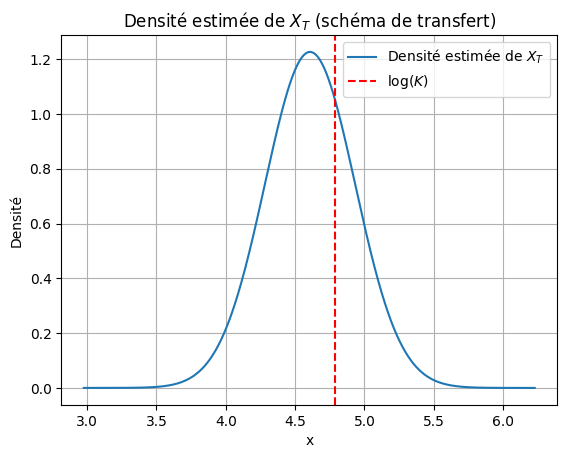

Estimation numérique P(X_T > log(K)) : 0.289928
Valeur exacte (normale)              : 0.284527
Erreur absolue                       : 0.005401


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


S0 = S_0


N = 2000                     # Pas de temps
dt = T / N
x0 = np.log(S0)
x_K = np.log(K)

# Grille spatiale affinée
x_min = x0 + mu * T - 5 * sigma * np.sqrt(T)
x_max = x0 + mu * T + 5 * sigma * np.sqrt(T)
M = 2000
dx = (x_max - x_min) / M
x_grid = np.linspace(x_min, x_max, M)

# === Initialisation de la densité ===
U = np.zeros((N + 1, M))
i0 = np.argmin(np.abs(x_grid - x0))
U[0, i0] = 1.0 / dx  # Approximation de Dirac

# === Noyau de convolution ===
L = 40  # demi-largeur
shift = np.arange(-L, L + 1)
kernel_vals = norm.pdf(shift * dx, loc=mu * dt, scale=sigma * np.sqrt(dt))
kernel_vals /= np.sum(kernel_vals)  # normalisation

# === Évolution temporelle ===
for n in range(N):
    U_next = np.zeros(M)
    for i in range(L, M - L):
        U_next[i] = np.sum(U[n, i - L:i + L + 1] * kernel_vals)
    U[n + 1] = U_next

# === Estimation de la probabilité P(X_T > log(K)) ===
idx = x_grid > x_K
p_estimate = np.sum(U[-1, idx]) * dx

# === Comparaison avec la valeur exacte ===
mu_T = x0 + mu * T
sigma_T = sigma * np.sqrt(T)
p_exact = 1 - norm.cdf((np.log(K) - mu_T) / sigma_T)

# === Affichage ===
plt.plot(x_grid, U[-1], label='Densité estimée de $X_T$')
plt.axvline(x_K, color='red', linestyle='--', label='$\log(K)$')
plt.title("Densité estimée de $X_T$ (schéma de transfert)")
plt.xlabel("x")
plt.ylabel("Densité")
plt.legend()
plt.grid()
plt.show()

# === Résultats ===
print(f"Estimation numérique P(X_T > log(K)) : {p_estimate:.6f}")
print(f"Valeur exacte (normale)              : {p_exact:.6f}")
print(f"Erreur absolue                       : {abs(p_estimate - p_exact):.6f}")


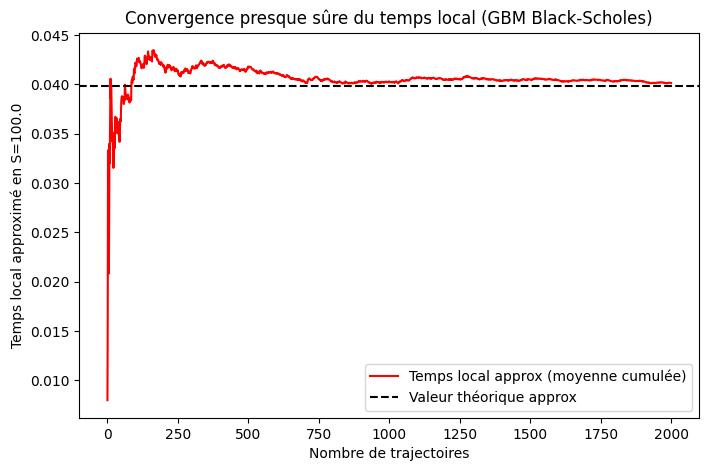

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres Black-Scholes
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.2
T = 1.0
n = 1000          # nombre de pas de temps
dt = T/n
N = 2000          # nombre de trajectoires
eps = 0.5         # epsilon pour approx indicateur

# Stocker les moyennes cumulées pour convergence
means = []
cumul_sum = 0.0

for k in range(1, N+1):
    S = np.zeros(n+1)
    S[0] = S0
    dW = np.sqrt(dt) * np.random.randn(n)

    # simulation du GBM
    for i in range(n):
        S[i+1] = S[i] * np.exp((r - 0.5*sigma**2)*dt + sigma*dW[i])

    # approximation du temps local à K
    LT_eps = np.sum((np.abs(S[:-1]-K) < eps)) * dt / (2*eps)

    cumul_sum += LT_eps
    means.append(cumul_sum/k)

# Valeur théorique approximée
# Pour un GBM on peut approx avec transformation log(S) ~ B_t
LT_theo = np.sqrt(2*T/np.pi) / (sigma * K)  # approx via transformation log(S/K) ~ BM

# Plot convergence
plt.figure(figsize=(8,5))
plt.plot(means, color='red',label='Temps local approx (moyenne cumulée)')
plt.axhline(LT_theo, color='black', linestyle='--', label='Valeur théorique approx')
plt.xlabel('Nombre de trajectoires')
plt.ylabel(f'Temps local approximé en S={K}')
plt.title('Convergence presque sûre du temps local (GBM Black-Scholes)')
plt.legend()
plt.show()


# Calcul de Malliavin et grecs

## Notations et définitions

***********************
### Notation

On considère un espace de probabilité $(Ω,\mathbb{F},\mathbb{P})$ sur lequel est défini un mouvement brownien $(B_t)_{t\geq 0}$ et on note $\mathbb{F}_t=\sigma(B_s,s\leq t)$.

On subdivise l'interval $[0,T]$ à l'aide des dyadique $t^n_k=\frac{k}{2^n} $ avec $n\in\mathbb{N}^*$ et $k\in\{0,...,2^n\}$

Enfin, on note $Δ^n_k=B_{t^n_{k+1}}-B_{t^n_{k}}$, les acroissement du brownien et $Δ^n=(Δ^n_0,...,Δ^n_{2^n-1})$

On introduit les espace simples sur lesquels on va définir nos deux operateur. $C^∞_p$ designe l'ensemble des fonctions infiniment derivables à croissance au plus polynomial
*********
**************
### Définitions
**Définition 1**

l'ensemble des fonction simples

$$S_n=\Big\{f(Δ^n_0,...,Δ^n_{2^n-1}); f\in C^∞_p(\mathbb{R}^{2^n}) \Big\}$$

les $S_n$ forment une suite croissante d'ensembles inclus dans $L_2(Ω)$, les éléments de $S=⋃ _{n\geq 0}S_n$  s'appellent fonctionnelles simples.

Cet ensemble nous permettera de définir la dérivé de Malliavin. L'espace des fonctionnelles simple est construit de telle sorte qu'apparaise clairement la dépendance d'une variable aléatoire de $S_n$ avec les accroissement du brownien
************
**********
**Définition 2**
l'ensemble des processus simples

$$P_n=\Big\{\sum _{i=0}^{2^n-1}𝟙 _{[t^n_i,t^n_{i+1}[}(t)F_i(ω)\text{ ;  } (t,ω)\in [0,T],Ω\text{ et } F_i\in S_n\Big\}$$

Les $P_n$ forment une suite croissante d'ensemble inclus dans $L_2([0,T]\times Ω)$.

Les element de $P=⋃_{n\geq1}P_n$ s'appellent processus simples.
*************
***********
**Définition 3**

soit $F\in S$, alors $∃n\in \mathbb{N}^*$tel que

$$F=f(Δ^n)$$
L'operateur de dérivation au sens de Malliavin de la fonctionelle simple $F$ en un point $s\in [t^n_i,t^n_{i+1}[$ est alors la fonction

$$D_sF=\sum _{i=0}^{2^n-1}𝟙 _{[t^n_i,t^n_{i+1}[}(s)∂_if(Δ^n)$$
Il est logique que cet operateur associe à une variable aléatoire un processus.

A la date $s$ la dérivée au sens de Malliavin traduit l'impacte des acroissement du brownien sur une variable aléatoire
***************
****************
**Définition 4 : l'operateur de dérivation de Skorokhod**

Soit $u\in P$, alors $∃n\in\mathbb{N}^*$ tel que $u\in P_n$.L'operateur d'integration au sens de Skorokhos du processus simple $u$ est

$$δ(u)=\sum _{i=0}^{2^n-1}f_i(Δ^n)Δ^n_i-\sum _{i=0}^{2^n-1}∂_if_i(Δ^n)\frac{1}{2^n}$$
avec

$$u(t,ω)=\sum _{i=0}^{2^n-1}𝟙 _{[t^n_i,t^n_{i+1}[}(t)F_i(ω) \text{ et } F_i=f_i(Δ^n)$$

Notons que le premier terme correspond à une integrale d'Ito, le second prend en compte le fait que le processus n'est pas necessairement adapté. Ce deuxieme terme est necessaire pour obtenir la relation d'integration par partie et a été integré dans la définition dans ce but.

Si on définit les processus prévisible par
$$∀k\in \big\{0,...,2^n-1\big\}, f_k(Δ^n)=f_k(Δ^n_0,...,Δ^n_{k-1})$$
On remarque que dans ce cas le deuxieme terme s'annule
**********
## Extention des operateur
Nous allons maintenant etendre les operateur $D$ et $δ$ à $L_2(Ω)$, $L_2([0,T],Ω)$
***********
**Proposition**

$D$ et $δ$ sont des operateur férmés, c'est à dire si $(F_n)_n$ est une suite de $S$ qui tends vers $0$ dans $L_2([0,T],Ω)$ et si $DF_n$ tends vers $u$ alors, $u=0$
************
************
**Définition 5**

On définit
$$\mathbb{D}^{1,2}=\Big\{F\in L_2(Ω) \text{ tq }∃(F_n)\in S\text{ tq }F_n\xrightarrow{L_2(Ω)}F \text{ et }DF_n\xrightarrow{L_2([0,T],Ω)}u\Big\}$$

on pose alors

$$Df=u$$
******************

*************
**Définition 6**

On définit

$$Dom(δ)=\Big\{u\in L_2([0,T],Ω) \text{ tq }∃(u_n)\in P \text{ tq }u_n\xrightarrow{L_2([0,T],Ω)}u \text{ et }\delta (u_n)\xrightarrow{L_2(Ω)}F\Big\}$$

On pose alors

$$F=δ(u)$$
**********

## formule d'integration par partie

************
**Proposition 1**

$∀F\in \mathbb{D}^{1,2}$ et $∀u\in Dom(δ)$

$$\mathbb{E}\Big\{∫_0^TD_sFu_sds\Big\}=\mathbb{E}\big\{Fδ(u)\big\}$$
On a donc la relation
$$\Big<DF,u\Big>_{L_2([0,T],Ω)}=\Big<F,\delta( u)\Big>_{L_2(Ω)}$$
**************
************
**Lemme 1**

Soit $Δ\sim N(0,2^{-n}I^{2^n}_d)$, alors pour $g$ dans $C^1(\mathbb{R}^{2^n})$

$$\mathbb{E}\big\{\partial_i g(Δ)\big\}=\frac{1}{2^{-n}}\mathbb{E}\big\{\Delta_i g(Δ)\big\}$$
**********
********
**Preuve du lemme 1**

la densité de $\Delta$ est

$$p(x)=\frac{1}{2\pi2^{-n}}exp\Big\{-\frac{1}{2}\frac{1}{2^{-n}}\mid\mid x\mid\mid^2\Big\}$$

On a

$$\mathbb{E}\big\{\partial_i g(Δ)\big\}=∫_{\mathbb{R}^{2^n}}\partial_ig(x)p(x)dx$$


On a par integration par partie
$$∫_{\mathbb{R}^{2^n}}\partial_ig(x)p(x)dx=-∫_{\mathbb{R}^{2^n}}g(x)\partial_ip(x)dx$$
Or,
$$\partial_ip(x)=-p(x)\frac{x_i}{2^{-n}}$$

Donc,

$$-∫_{\mathbb{R}^{2^n}}g(x)\partial_ip(x)dx=∫_{\mathbb{R}^{2^n}}g(x)p(x)\frac{x_i}{2^{-n}}dx$$

Donc,

$$\begin{align*}
-∫_{\mathbb{R}^{2^n}}g(x)\partial_ip(x)dx&=\frac{1}{2^{-n}}∫_{\mathbb{R}^{2^n}}x_ig(x)p(x)dx\\
&=\frac{1}{2^{-n}}\mathbb{E}\big\{\Delta_i g(Δ)\big\}
\end{align*}$$

Donc ,

$$\mathbb{E}\big\{\partial_i g(Δ)\big\}=\frac{1}{2^{-n}}\mathbb{E}\big\{\Delta_i g(Δ)\big\}$$
************
***********
**Preuve de la proposition 1**

Soit $F\in S_n$ et $u\in P_n$

Appliquons le lemme 1 à la fonction $g=f_if$, on a

$$\partial_i(f_if)=\partial_if_if+f_i\partial_if$$

Donc,

$$\mathbb{E}\Big\{f_i\partial_if\Big\}=\mathbb{E}\Big\{\partial_i(f_if)\Big\}-\mathbb{E}\Big\{\partial_if_if\Big\}$$
Or,

$$\mathbb{E}\Big\{\partial_i(f_if)\Big\}=\frac{1}{2^{-n}}\mathbb{E}\big\{\Delta_i f_if\big\}$$

Donc,

$$\mathbb{E}\Big\{f_i\partial_if\Big\}=\mathbb{E}\Big\{f\Big(\frac{Δ_i^n}{2^{-n}}f_i-∂_if_i\Big)\Big\}$$
Donc,

$$\begin{align*}
\mathbb{E}\Big\{∫_0^TD_sFu_sds\Big\}&=\sum _{i=0}^{2^n-1}\mathbb{E}\Big\{∂_if(Δ^n)f_i(Δ^n)\Big\}\frac{1}{2^n}\\
&=\sum _{i=0}^{2^n-1}\mathbb{E}\Big\{f(Δ^n)\Big(\frac{Δ_i^n}{2^{-n}}f_i(Δ^n)-∂_if_i(Δ^n)\Big)\Big\}\frac{1}{2^n}\\
&=\mathbb{E}\Big\{F\Big(\sum _{i=0}^{2^n-1}f_i(Δ^n)Δ^n_i-\sum _{i=0}^{2^n-1}∂_if_i(Δ^n)\frac{1}{2^n}\Big)\Big\}\\
&=\mathbb{E}\big\{Fδ(u)\big\}
\end{align*}$$

*****************

## Application au modèle de Black Scholes

### Calcul du Delta d'un call

avec

$$S_T=S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}=S_0Y_T$$
On veux calculer

$$Δ=\frac{∂}{∂S_0}e^{-rT}\mathbb{E}\Big\{F\Big\} \text{, avec } F=f(S_T)\text{, et } f(x)=(x-K)_+$$


On a donc,

$$D_sF=f'(S_T)D_sS_T=f'(S_T)σS_T𝟙_{[0,T]}(s)$$
Donc, avec

$$u_s=\frac{1}{σS_0T}𝟙_{[0,T]}(s)$$

On obitient que ,

 $$\begin{align*}
 \Big<DF,u\Big>_{L_2([0,T],Ω)}&=∫_0^TD_sFu_sds\\
 &=f'(S_T)\frac{S_T}{S_0T}∫_0^Tds\\
 &=f'(S_T)\frac{S_T}{S_0}\\
 &=\frac{∂F}{∂S_0}
 \end{align*}$$

 Donc,

 $$\begin{align*}
 \frac{∂}{∂S_0}\mathbb{E}\Big\{F\Big\}&=\mathbb{E}\Big\{\frac{∂F}{∂S_0}\Big\}\\
 &=\mathbb{E}\Big\{∫_0^TD_sFu_sds\Big\}\\
 &=\mathbb{E}\big\{Fδ(u)\big\}
 \end{align*}$$

 avec

 $$δ(u)=\int_0^Tu_sdB_s=\frac{B_T}{σS_0T}$$
 On touve finalement que

 $$Δ=\mathbb{E}\big\{f(S_T)\frac{e^{-rT}B_T}{σS_0T}\big\}$$

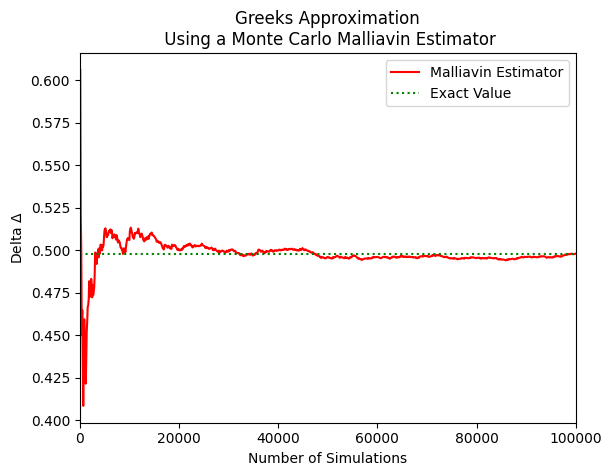

In [ ]:
def payoff(x, kind="call"):
    if kind == "call":
        return np.maximum(x-K, 0)
    elif kidn == "put":
        return np.maximum(K - x, 0)
    else:
        return 0

sigma=sigma_prim
x0=S_0
d_plus = (np.log(x0/K)+(r + 0.5*sigma**2)*T)*(1.0/(sigma*np.sqrt(T)))
d_minus = d_plus - sigma*np.sqrt(T)
std_normal = norm(loc=0, scale=np.sqrt(1))
delta = std_normal.cdf(d_plus)


def estimate_delta_malliavin(payoff, r, sigma, x0, T, N):


    browniam_marginal = norm(loc=0, scale=np.sqrt(T))
    brownian_sample = browniam_marginal.rvs(N)
    gbm_sample = x0*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)

    constant = np.exp(-1.0*r*T)/(sigma*x0*T)

    deltas = []
    sizes = range(100, N+1, 100)
    for k in sizes:

        mc_estimator = np.mean(payoff(gbm_sample[:k])*brownian_sample[:k])
        delta = constant*mc_estimator
        deltas.append(delta)


    return sizes, deltas

N = 100000
sizes, malliavin_deltas = estimate_delta_malliavin(payoff=payoff,  r=r, sigma=sigma, x0=x0, T=T, N=N)

plt.rcParams.update(plt.rcParamsDefault)
plt.plot(sizes, malliavin_deltas, color="red", label="Malliavin Estimator")
plt.hlines(delta, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator")
plt.legend()
plt.show()

## Convergence monte carlo

On veut calculer

$$Δ=e^{-rT}\frac{∂}{∂S_0}\mathbb{E}\Big\{f(S_T)\Big\}$$

Alors, l'estimateu,

$$\hat{\Delta}_N=e^{-rT} \frac{1}{N}∑_{i=0}^N\frac{f(S^{(i,+)})-f(S^{(i,-)})}{2ϵ}$$

Avec

$$S^{(i,\pm)}=(S_0\pmϵ)exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}$$

converge presque surement vers $\Delta$, en effet,

La fonction
$$x→\mathbb{E}\Big\{f(S_T(x))\Big\}$$
Est dérivable en $S_0$, donc, avec,
$$S_T(x)=x exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}$$

Alors,

$$\frac{e^{-rT}}{2 ϵ}\Big(\mathbb{E}\Big\{f(S_T(S_0+ϵ))\Big\}-\mathbb{E}\Big\{f(S_T(S_0-ϵ))\Big\}\Big)⟶Δ \text{Quand $ϵ$ tends vers } 0$$

Donc,

$$\hat{\Delta}_N⟶Δ \text{Quand $ϵ$ tends vers } 0 \text{ et $n$ vers l'infini}$$

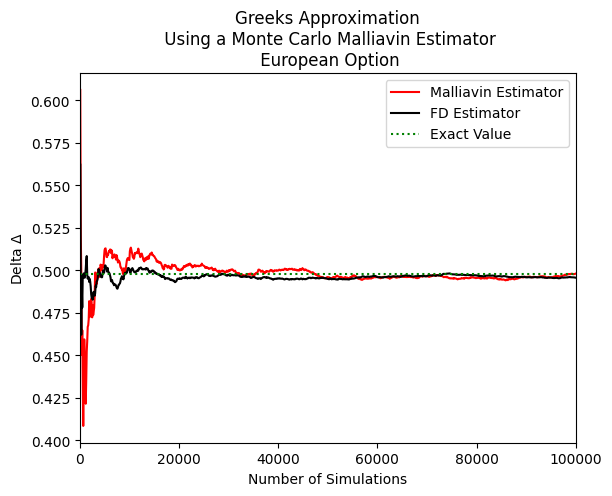

In [ ]:
def estimate_delta_fd(payoff, r, sigma, x0, T, N, epsilon=0.001):

    browniam_marginal = norm(loc=0, scale=np.sqrt(T))

    brownian_sample = browniam_marginal.rvs(N)
    gbm_sample_up= (x0 + epsilon)*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)
    gbm_sample_down = (x0 - epsilon)*np.exp((r - 0.5*sigma**2)*T + sigma*brownian_sample)
    constant = np.exp(-1.0*r*T)

    pv_plus = payoff(gbm_sample_up)
    pv_minus = payoff(gbm_sample_down)

    deltas = []
    sizes = range(100, N+1, 100)
    for k in sizes:

        fd = np.mean((pv_plus[:k] - pv_minus[:k])/(2.0*epsilon))
        delta = constant*fd
        deltas.append(delta)

    return sizes, deltas


sizes, fd_deltas = estimate_delta_fd(payoff=payoff, r=r, sigma=sigma, x0=x0, T=T, N=N)

plt.plot(sizes, malliavin_deltas, color="red", label="Malliavin Estimator")
plt.plot(sizes, fd_deltas, color="black", label="FD Estimator")
plt.hlines(delta, 0, sizes[-1], color="green", linestyle=":", label="Exact Value")
plt.xlim([0.0, sizes[-1]])
plt.ylabel("Delta $\Delta$")
plt.xlabel("Number of Simulations")
plt.title("Greeks Approximation\n Using a Monte Carlo Malliavin Estimator\n European Option")
plt.legend()
plt.show()


# Introduction
L’objectif de ce travail est d’évaluer la probabilité de ruine en temps fini d'une compagnie d'assurance. On modélise alors la richése détenue par l'assurance au temps t par:

$$R_t=u+ct-S_t$$
Ou

+  $u\geq0$: La richésse initiale de l'assureur.

+ $c\geq0$: Taux instantané de prime.

+ $S_t=\sum_{i=1}^{N_t}X_i$.

+ $X_i$ Montant du i-éme sinistre qui suit une loi exponentielle de parametre $\mu_{orig}$.

+ $N_t$: Un processus de poisson.

*******************
**Définition**

On défini alors les probalités de ruine et de survie a horizon fini:
$$\Psi(u,T)=\mathbf{P}\left(R_T>0\mid R_0=u\right)=\mathbb{E}^{\mathbb{P}}\Big\{𝟙_{\{R_T>0\}}\Big\}$$
*******************
On a d'apres le theoréme de girsanov,
$$\mathbb{E}^{\mathbb{P}}\Big\{𝟙_{\{R_T>0\}}\Big\}=\mathbb{E}^{\mathbb{Q}}\Big\{𝟙_{\{R_T>0\}}L_T\Big\}$$

Avec,
$$L_T=∏_{k=0}^{N_T}\frac{f^{\mathbb{P}}(S_k)}{f^{\mathbb{Q}}(S_k)}=∏_{k=0}^{N_T}\frac{\mu_{orig}}{\mu_{tilt}}e^{-(\mu_{orig}-\mu_{tilt})S_k}$$

Donc,

$$\frac{1}{n}\sum_{i=0}^n𝟙_{\{R_T^{(i)}>0\}}L_T^{(i)} \text{ Converge presque surement vers } \Psi(u,T)$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
lambda_orig = 5.
mu_orig = 1.
to = 0.8
Ee = 1./mu_orig
c = (1 + to) * lambda_orig * Ee
u_ini = Ee
t_final = 1.

n_sim = 5000


mu_tilt = 0.8

def simulate_girsanov():
    u = u_ini
    t = 0.
    L = 1.

    while t < t_final and u >= 0:

        T = np.random.exponential(1/lambda_orig)
        if t + T > t_final:
            break
        t += T


        S = np.random.exponential(1/mu_tilt)


        w_sinistre = (mu_orig / mu_tilt) * np.exp(-(mu_orig - mu_tilt)*S)


        L *= w_sinistre


        u += c*T - S

    return (1 if u >= 0 else 0), L


results = np.array([simulate_girsanov() for _ in range(n_sim)])

indicators = results[:,0]
weights = results[:,1]

estimateurs_pondérés = indicators * weights


cumulative_means2 = np.cumsum(estimateurs_pondérés) / np.arange(1, n_sim + 1)




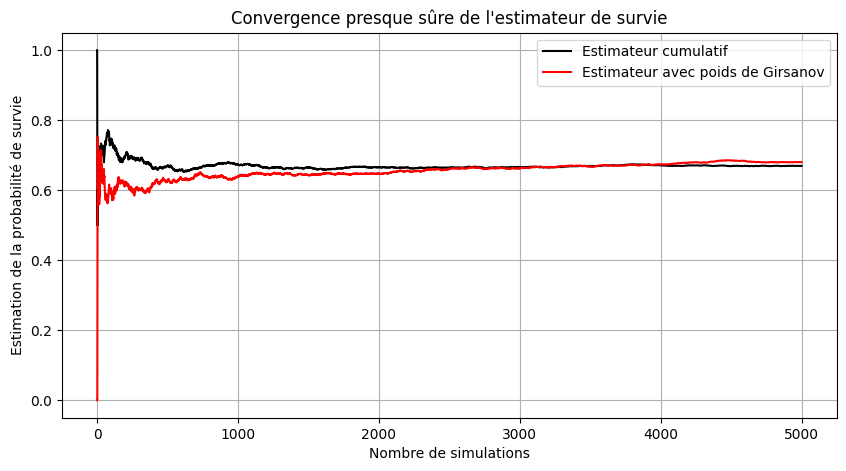

In [ ]:
import random


mu_orig = 1.
a = 3.
b = 3.
to = 0.8
t_final = 1.
lambdaa = 5.
mu = 1.
Ee = 1./mu
c = (1 + to)*lambdaa*Ee
u_ini = Ee


def simulate_survival():
    u = u_ini
    T = np.random.exponential(1/lambdaa)
    t = T
    while u >= 0 and t < t_final:

        S = np.random.exponential(1/mu_orig)
        u += c * T - S
        T = np.random.exponential(1/lambdaa)
        t += T
    return 1 if u >= 0 else 0



n_simulations = 5000
survival_indicators = [simulate_survival() for _ in range(n_simulations)]



cumulative_means = np.cumsum(survival_indicators) / np.arange(1, n_simulations + 1)



plt.figure(figsize=(10, 5))
plt.plot(cumulative_means, color='black', label='Estimateur cumulatif')
plt.plot(cumulative_means2,color='red', label='Estimateur avec poids de Girsanov')
plt.xlabel("Nombre de simulations")
plt.ylabel("Estimation de la probabilité de survie")
plt.title("Convergence presque sûre de l'estimateur de survie")
plt.grid(True)
plt.legend()
plt.show()


# Approximation des mesures marginales

Soit $t\geq0$, $\mu_t$ une mesure de probabilité sur $\mathbb{R}_+$ et telle que :
$$\mathbb{P}\left(R_t>0\right)=\int_{\mathbb{R}_+}d\mu_t$$
Soit $E\in\mathcal{P}(\mathbb{R}_+)$ une partie mesurable, on a alors
\begin{align*}
\mathbb{P}\left(R_{t+h}\in E\right) &= \mathbb{P}(N_{t+h}-N_t=0)\mathbb{P}\left(R_{t}\in \tau_{-ch}(E)\right)+\mathbb{P}(N_{t+h}-N_t=1)\mathbb{P}\left(R_{t+h}\in \tau_{X}(E),X\right) \\
&=(1-\lambda h)\mathbb{P}\left(R_{t}\in \tau_{-ch}(E)\right)+\lambda h\mathbb{P}\left(R_{t+h}\in \tau_{X}(E),X\right)  
\end{align*}
Ou $\tau_{_{-ch}}(E):=\{r\in\mathbb{R} \text{ ; } r+ch\in E\}$ et $X$ suit la même loi du montant des sinistres.\\

On peut voir alors que
$$\int_{\mathbb{R}_+}\mathbf{1}_E(s)d\mu_{t+h}(s)=(1-\lambda h)\int_{\mathbb{R}_+}\mathbf{1}_E(s+ch)d\mu_{t}(s)+\lambda h \int_{\mathbb{R}}\int_{\mathbb{R}_+}\mathbf{1}_E(s-u)d\mu_{t}(s)dF(y)$$



Soit $(E_i)_{i\geq0}$ une partition de $[0 , N]$, et $\phi\in\mathcal{C}_c^1(\mathbb{R})$ telle que $\phi=\sum_{i\in I}\phi_i\mathbf{1}_{E_i}$, avec $(\phi_i)_{i\in I}$ des fonctions telles que $\forall i \in I$, $\phi_i\in\mathcal{C}_c^1(\mathbb{R})$. On a alors, en faisant tendre $h$ vers $0$
$$\partial_t\int_{\mathbb{R}_+}\phi(s)d\mu_{t}(s)=c\int_{\mathbb{R}_+}\phi'(s)d\mu_{t}(s)-\lambda\int_{\mathbb{R}_+}\phi(s)d\mu_{t}(s)+\lambda\int_{\mathbb{R}}\int_{\mathbb{R}_+}\phi(s-y)d\mu_{t}(s)dF(y)\text{  } (2)$$
Et $d\mu_0=\delta_u$


*Remarque:* $\mu_.(.)$ est alors solution faible de l'équation (1)

## Schéma de Volumes finis pour approcher $\mu$
Au temps $t_n=\frac{nh}{c}$, on approche  $d\mu_{t_n}$ par une densité constante par morceaux $(U^n_i)_{i\in\mathbb{N}}$.

On a alors pour $i \in \mathbb{N}$ et $t\in\left](n-1)\frac{h}{c} \text{ , } n\frac{h}{c}\right]$
$$U_i^n\cong \frac{1}{h}\int_{ih}^{(i+1)h}d\mu t=\frac{1}{h}\mathbb{P}\left(R_t\in[ih , (i+1)h[\right)$$
Donc
$$h\sum_{i\in\mathbb{N}}U_i^n\cong \sum_{i\in\mathbb{N}}\int_{ih}^{(i+1)h}d\mu t=\int_{\mathbb{R}_+}d\mu_t=\mathbb{P}\left(R_t>0\right)$$
La discretisation de l'équation (2) se fait de la manière suivante:
### Initialisation en temps
Au temps $t_0=0$ on approche $d\mu_0=\delta_u$ par $(U_i^0)_{i\in\mathbb{N}}$, ou pour $i\in\mathbb{N}$
$$U_i^0=\frac{u_0}{h}\mathbf{1}_{\{u_0\in[ih , (i+1)h[\}}$$
### Avancement temporel
On utilise le schéma suivant pour les pas de temps: Pour $n\geq 0$
$$U^{n+1}_i=\frac{1}{1+\delta t}\left(U_{i-1}^n+\delta t \lambda\sum_{j\in\mathbb{N}}U^n_{i+j}(F((j+1)h)-F(jh))\right)$$
## Résultats numériques:
On obtient une probabilité de survie pour les trois types de sinistres:



Probabilité de survie approchée à t_final = 0.6789389908021873


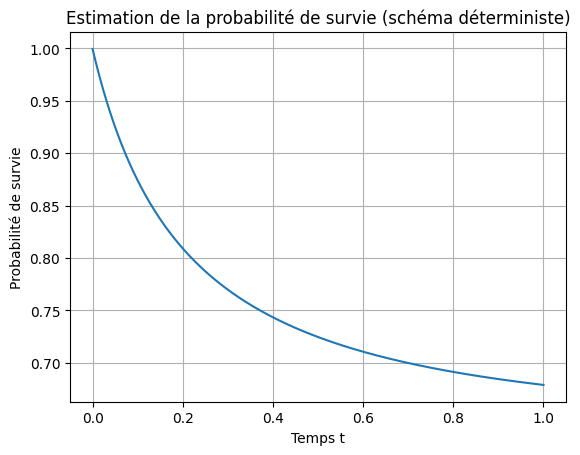

In [ ]:
import matplotlib.pyplot as plt
from math import exp
import numpy as np

# Paramètres du modèle
mu_orig = 1.0
a = 3.0
b = 3.0
to = 0.8
t_final = 1.0
lambdaa = 5.0
mu = 1.0
Ee = 1.0 / mu
c = (1 + to) * lambdaa * Ee
uini = Ee

# Discrétisation
deltau = 0.0025  # pas en richesse u
iini = int(uini / deltau)  # indice de la position initiale
deltat = deltau / c        # CFL : deltat = deltau / c

# Nombre de points nécessaires
N = iini + int(t_final / deltat) + 10  # on ajoute un petit tampon

# Initialisation de la densité (Dirac au point initial)
u = [0.0 for _ in range(N)]
u[iini] = 1.0 / deltau

# Paramètres sinistre
lambdt = lambdaa * deltat
uplambdt = 1.0 / (1.0 + lambdt)

# Discrétisation de la loi exponentielle de sinistres
X = [i * deltau for i in range(N + 2)]
dF = [lambdt * (exp(-mu * X[i]) - exp(-mu * X[i + 1])) for i in range(N + 1)]

# Évolution temporelle
t = 0.0
Nmax = iini + 1
conv = []

while t < t_final:
    t += deltat
    Nmax += 1
    un = u.copy()

    # Bord gauche
    u[0] = uplambdt * sum(un[j] * dF[j] for j in range(Nmax))

    # Mise à jour des autres points
    for i in range(1, Nmax):
        somme_conv = sum(un[i + j] * dF[j] for j in range(Nmax - i))
        u[i] = uplambdt * (un[i - 1] + somme_conv)

    conv.append(sum(u) * deltau)  # probabilité de survie à chaque t

print("Probabilité de survie approchée à t_final =", sum(u) * deltau)

# Courbe de convergence
plt.plot(np.linspace(0, t_final, len(conv)), conv)
plt.xlabel("Temps t")
plt.ylabel("Probabilité de survie")
plt.title("Estimation de la probabilité de survie (schéma déterministe)")
plt.grid()
plt.show()


# END

Soient $Y_n=(X_n-a)^+$ et $T_0=0$

On définit
$$H_n=\sum_{k=0}^{∞}𝟙_{\{S_k<n\leq T_k\}}$$

Avec,

 $$\begin{cases}
      S_{k+1} =inf\Big\{n>T_k; X_n\leq a\Big\} \\
      T_{k+1} =inf\Big\{n>S_{k+1}; X_n\geq b\Big\}
\end{cases}$$

Comme chaque indice $𝟙_{\{S_k<n\leq T_k\}}$ est $\mathbb{F}_{n-1}$ mesurable, leur somme $H_n$ est aussi $\mathbb{F}_{n-1}$ mesurable, cela garantie que $H_n$ est prévisible, condition necéssaire pour que la transformation suivante soit une suremartingale:


$$\begin{align*}
(H.Y)_n&=\sum_{j=0}^nH_j(Y_j-Y_{j-1})\\
&=\sum_{k=0}^{N^n}\sum_{j=S_k+1}^{T_k}(Y_j-Y_{j-1})+\sum_{k=S_{N^n}+1}^{n}(Y_j-Y_{j-1})\\
&=\sum_{k=0}^{N^n}(Y_{T_k}-Y_{S_k})+𝟙_{\{S_{N^n}+1<n\}}(Y_n-Y_{S_{N^n}+1})
\end{align*}$$

Inégalité sur les termes:
Pour chaque monté k, on a
+  $X_{T_k}\geq b$, donc,
$$Y_{T_k}=(X_{T_k}-a)^+\geq b-a$$
+ et $X_{S_k}\leq a$, donc:
$$Y_{S_k}=(X_{S_k}-a)^+=0$$
On trouve alors que

$$Y_{T_k}-Y_{S_k}\geq b-a$$

Pour la monté $(Y_n-Y_{S_{N^n}+1}\geq 0$ car,

+ $Y_n\geq 0$

+ $Y_{S_{N^n}+1}= 0$

On a finalement

$$(H.Y)_n\geq\sum_{k=0}^{N^n}(b-a)=(b-a)N^n $$

Donc en prenant l'esperance,

$$\mathbb{E}\Big\{(H.Y)_n\Big\}\geq(b-a)\mathbb{E}\Big\{N^n\Big\} $$

Avec $K_n=1-H_n$ on a

$$(K.Y)_n+(H.Y)_n=\Big((H+K).Y\Big)_n=(1.Y)_n=Y_n-Y_0$$
Comme $Y$ est une sous martingale et $K$ prévisible positive, alors,

$$\mathbb{E}\Big\{(K.Y)_n\Big\}\geq 0$$

Donc,

$$\mathbb{E}\Big\{(H.Y)_n\Big\}\leq \mathbb{E}\Big\{Y_n-Y_0\Big\}$$

Donc
$$\begin{align*}
(b-a)\mathbb{E}\Big\{N^n\Big\}&\leq \mathbb{E}\Big\{Y_n-Y_0\Big\}\\
&=\mathbb{E}\Big\{(X_n-a)^+\Big\}-\mathbb{E}\Big\{(X_0-a)^+\Big\}\\
&=\mathbb{E}\Big\{(X_n-a)^+\Big\}
\end{align*}$$


**Lemme 1**

Soit $Δ\sim N(0,σ^2)$, alors pour $f,g$ dans $C^1(\mathbb{R})$

$$\mathbb{E}\big\{f'(Δ)g(Δ)\big\}=\mathbb{E}\Big\{f(Δ)\big(\frac{Δ}{σ^2}g(Δ)-g'(\Delta)\big)\Big\}$$
**********
********
**Preuve du lemme 1**

On a
$$\begin{align*}
\mathbb{E}\big\{f'(Δ)g(Δ)\big\}&=∫_{\mathbb{R}}f'(x)g(x)\frac{e^{-\frac{x^2}{2σ^2}}}{\sqrt{2\piσ^2}}dx\\
&=\Big[f(x)g(x)\frac{e^{-\frac{x^2}{2σ^2}}}{\sqrt{2\piσ^2}}\Big]_{\mathbb{R}}-∫_{\mathbb{R}}f(x)\Big(g'(x)-\frac{x}{\sigma^2}g(x)\Big)\frac{e^{-\frac{x^2}{2σ^2}}}{\sqrt{2\piσ^2}}dx\\
&=\mathbb{E}\Big\{f(Δ)\big(\frac{Δ}{σ^2}g(Δ)-g'(\Delta)\big)\Big\}
\end{align*}$$
************

$3M→1Y$ est compsé de deux sous partie $6M→1Y$ et $3M→6M$

On a

$$B_{3M→1Y} =\frac{\underset{k\in ]3M,1Y]}{\sum}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{1Y})}{Bpv^{1Y}}$$

La jambe courte $3M→6M$

$$B_{3M→6M} =\frac{\underset{k\in ]3M,6M]}{\sum}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{6M})}{Bpv^{6M}}$$


La jambe $6M→1Y$
$$B_{6M→1Y} =\frac{\underset{k\in ]6,1Y]}{\sum}α_k^{6M}P_k^{6M}(L_k^{6M}+CimValue^{6M}_{1Y})}{Bpv^{1Y}}$$

La somme totale sur $3M→1Y$ se decompose de la maniere suivante:

$$\underset{k\in ]3M,1Y]}{\sum}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{1Y})=\underset{k\in ]3M,6M]}{\sum}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{6M})+\underset{k\in ]6,1Y]}{\sum}α_k^{6M}P_k^{6M}(L_k^{6M}+CimValue^{6M}_{1Y})$$

Remplaçons dans$B_{3M→1Y}$,



$$\begin{align*}
B_{3M→1Y} &=\frac{1}{Bpv^{1Y}}\Big(\underset{k\in ]3M,6M]}{\sum}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{6M})+\underset{k\in ]6,1Y]}{\sum}α_k^{6M}P_k^{6M}(L_k^{6M}+CimValue^{6M}_{1Y})\Big)\\
&=\frac{1}{Bpv^{1Y}}\big(Bpv^{6M}B_{3M→6M}+Bpv^{1Y}B_{6M→1Y}\big)
\end{align*}$$

Donc,

$$B_{3M→1Y}=B_{3M→6M}\frac{Bpv^{6M}}{Bpv^{1Y}}+B_{6M→1Y}$$

Substituons

$$\begin{align*}
Cim^{3M}_{1Y} &=A_{1Y}-B_{3M→6M}\frac{Bpv^{6M}}{Bpv^{1Y}}-B_{6M→1Y}\\
&=(A_{1Y}-B_{6M→1Y})-(B_{3M→6M}-A_{6M}+A_{6M})\frac{Bpv^{6M}}{Bpv^{1Y}}\\
&=Cim^{3M}_{6M}\frac{Bpv^{6M}}{Bpv^{1Y}}+Cim^{6M}_{1Y}
\end{align*}$$

# Modèle de Black and Scholes et Ajustement de Valorisation stochastique


## Modèle de black scholes

### Méthode Monte Carlo
Soit
$$S_t=\frac{1}{r}\sigma dB_t-\frac{1}{r}dS_t$$

On suppose que le prix $S_t$ d'une action A suit la dynamique suivante:

$$dS_t=S_t\left(rdt+\sigma dB_t\right)$$

Où

$$X_t=ln(S_t)$$

donc

$$dX_t=(r-\frac{\sigma^2}{2})dt+\sigma dB_t$$












Soit $Y_t=exp(-rt+X_t)=exp(-rt)S_t$
donc,

$$dY_t=X_tY_tdt+Y_tdX_t+\frac{1}{2}\sigma^2Y_tdt=Y_t(r-\frac{\sigma^2}{2}dt+\sigma dB_t)+\frac{1}{2}\sigma^2Y_tdt=X_tY_tdt+Y_t\left(rdt+\sigma dB_t\right)$$

donc

$$dY_t=X_tY_tdt+exp(-rt)dS_t=exp(-rt)(S_tln(S_t)+dS_t)$$


On a alors,$$X_{n+1}-X_{n}=(r-\frac{\sigma^2}{2})\frac{1}{n}+\sigma \frac{1}{\sqrt{n}}G=-\theta_nB(S_n,G_{n+1})$$









$$\begin{cases}
      r= 5\text{% : taux d'actualisation} & \\
      \sigma \text{ : la volatilité} & \\
      B_t \text{ : Un mouvement brownien standard, } B_t \sim \mathcal{N}(0,\,t) &
    \end{cases}$$

la solution de cette EDS est la diffusion suivante $\forall t\geq 0$ et $\sigma \in [0,1]$:

$$S_t(\sigma)=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma B_t\right\}=S_0exp\left\{(r-\frac{\sigma^2}{2})t+\sigma \sqrt{t} G\right\}$$

On définit alors le prix d'un call europeen dont le sous jacent est A de la maniere suivante:

$$C(\sigma)=\mathbb{E}\left[e^{-rT}(S_T(\sigma)-K)_+\right]=\mathbb{E}\left[\mathbb{1}_{e^{-rT}(S_T(\sigma)-K)>0}e^{-rT}(S_T(\sigma)-K)\right]$$


On a $\forall t>0$

$$e^{-rT}(S_T(\sigma)-K)>0 \iff S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}>0$$

$$\iff S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma B_T\right\}>0$$

On a aussi avec $d_t=1/n$ et $\theta_n=\frac{1}{\sqrt{n}}$
$$S_{n+1}-S_{n}=-\theta_nB(S_n,G_{n+1})$$
avec
$$B(S_n,G_{n+1})=\frac{S_n}{n}\left(r+\sigma \sqrt{n} G\right)$$

soit la suite de variable aleatoires
$$V_i=(S_T-K)_{+}=\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G_i\right\}-K\right)_{+}$$
avec
$$t_i=\frac{i}{n} \text{  pour 0$\leq$ i$\leq$ n}$$

Soit
$$M_n=\frac{V_0+....+V_n}{n} \text{, alors, $M_n$ converge présque surement vers } C \text{ le prix d'un call}$$

On a avec $\gamma_n=\frac{1}{n+1}$

$$M_{n+1} = M_n -\gamma_n \left(M_n - V_{n+1}\right)= M_n -\gamma_n F \left(M_n , V_{n+1}\right)$$
En effet,

$$\begin{align*}
M_{n+1}-M_n&=\frac{n\sum_{i=1}^{n+1}V_i-(n+1)\sum_{i=1}^nG_i}{n(n+1)}&\\
&=\frac{V_{n+1}}{n+1}-\frac{M_n}{n+1}&\\
&=-\gamma_n(M_n-V_{n+1})
\end{align*}$$

Soit $f(x)=x-C$  et $x'$ tel que $f(x')=x'-C=0$ et $G$ une gaussienne centrée réduite, donc $\mathbb{E}[G]=0$ et $Var[G]=1$.

On a alors avec $F(x,G)=x-H(\sigma,G)$

avec

$$F(\sigma,G)=e^{-rT}\left(S_0exp\left\{(r-\frac{\sigma^2}{2})T+\sigma \sqrt{T}G\right\}-K\right)_+$$
donc

$$f(x)=\mathbb{E}[F(x,G)]=x-C$$


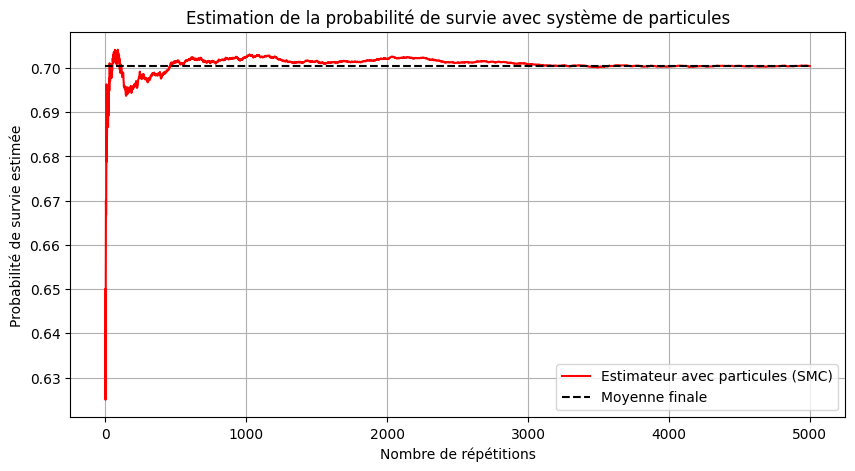

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform, exponential, normal

# Paramètres
n_particles = 60         # M (nombre de particules)
n_iterations = 5000      # N (nombre de répétitions pour estimer la proba)
time_horizon = 1.0       # T final
n_steps = 90             # discrétisation du temps
dt = time_horizon / n_steps

# Paramètres du modèle d'assurance
a, b = 3., 3.
to = 0.8
lambdaa = 5.
mu = 1.
Ee = 1./mu
cp = (1 + to) * lambdaa * Ee
u_ini = Ee

# Stockage
means = []
cumulative = 0

for iteration in range(1, n_iterations + 1):
    # Initialisation
    U = np.full(n_particles, u_ini)
    weights = np.ones(n_particles) / n_particles
    norm = 1.0
    alive = np.ones(n_particles)  # 1 = vivante, 0 = ruinée

    for step in range(n_steps):
        # Tirages des inter-arrivées
        delta_t = exponential(1 / lambdaa, size=n_particles)
        claim_occurs = delta_t < dt

        # Primes reçues pendant dt
        U += cp * dt

        # Sinistres éventuels
        S = exponential(1 / mu, size=n_particles)
        U -= claim_occurs * S

        # Vérifier ruine
        alive = np.where(U >= 0, alive, 0)
        U = np.where(U >= 0, U, 0)

        # Poids (pas d'importance ici mais pour illustrer le principe)
        weights = alive / np.sum(alive) if np.sum(alive) > 0 else weights

        # Rééchantillonnage (type SMC) si trop peu de particules survivent
        ess = 1.0 / np.sum(weights**2)
        if ess < n_particles / 2:
            # Rééchantillonnage systématique
            cdf = np.cumsum(weights)
            u0 = np.random.uniform(0, 1 / n_particles)
            u = u0 + np.arange(n_particles) / n_particles
            indices = np.searchsorted(cdf, u)
            U = U[indices]
            alive = alive[indices]
            weights = np.ones(n_particles) / n_particles
            norm *= np.mean(alive)

    # Estimateur final de survie : moyenne des indicatrices
    estimate = np.mean(alive)
    cumulative += estimate
    means.append(cumulative / iteration)

# Affichage de la convergence
plt.figure(figsize=(10,5))
plt.plot(means, label='Estimateur avec particules (SMC)', color='red')
plt.hlines(y=np.mean(means[-100:]), xmin=0, xmax=n_iterations, color='black', linestyle='--', label='Moyenne finale')
plt.xlabel("Nombre de répétitions")
plt.ylabel("Probabilité de survie estimée")
plt.title("Estimation de la probabilité de survie avec système de particules")
plt.legend()
plt.grid()
plt.show()


# Cim Basis

On a avec


$$\begin{cases}
      A_Y =\frac{1-P_Y}{Bpv^{Y}} \\
      B_{X→Y} =\frac{\underset{t\in X∩]0,Y]}{\sum}α_t^XP_t^X(L_t^X+CimValue^{X}_{Y})}{Bpv^{Y}}\\
      Bpv^{Y}=\underset{t\in X∩]0,Y]}{\sum}α_t^XP_t^X
\end{cases}$$

Supposons que nous avons 3 horizons, $3M→6M$, $6M→1Y$ et $3M→1Y$ on a alors
$$\begin{cases}
Bpv^{3M}=\underset{t\in ]0,3M]}{\sum}α_t^{3M}P_t^{3M}\\
Bpv^{6M}=\underset{t\in ]0,6M]}{\sum}α_t^{3M}P_t^{3M}\\
Bpv^{1Y}=\underset{t\in ]0,1Y]}{\sum}α_t^{3M}P_t^{3M}
\end{cases}$$

On a aussi

$$\begin{cases}
Cim^{3M}_{6M}=A_{6M}-B_{3M→6M}=-CimValue^{3M}_{6M}\frac{Bpv^{3M}}{Bpv^{6M}}\\
Cim^{6M}_{1Y}=A_{1Y}-B_{6M→1Y}=-CimValue^{6M}_{1Y}\frac{Bpv^{6M}}{Bpv^{1Y}}\\
Cim^{3M}_{1Y}=A_{1Y}-B_{3M→1Y}=-CimValue^{3M}_{1Y}\frac{Bpv^{3M}}{Bpv^{1Y}}\\
\end{cases}$$




On a avec $T$ la maturité

$$Δ=A_{1Y}-\frac{1}{Bpv^{1Y}}\underset{k\in freq 3M}{\sum^T}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{6M}+CimValue^{6M}_{1Y})-Cim^{3M}_{6M}\frac{Bpv^{6M}}{Bpv^{1Y}}+Cim^{6M}_{1Y}$$

Donc,

$$\Delta =A_{1Y}-\frac{1}{Bpv^{1Y}}\underset{k\in freq 3M}{\sum^T}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{6M}+CimValue^{6M}_{1Y})-\Big(A_{6M}-\frac{1}{Bpv^{6M}}\underset{k\in freq 3M}{\sum^T}α_k^{3M}P_k^{3M}(L_k^{3M}+CimValue^{3M}_{6M})\Big)\frac{Bpv^{6M}}{Bpv^{1Y}}-A_{1Y}+\frac{1}{Bpv^{1Y}}\underset{k\in freq 6M}{\sum^T}α_k^{6M}P_k^{6M}(L_k^{6M}+CimValue^{6M}_{1Y})$$



Donc

$$Δ=-\frac{1}{Bpv^{1Y}}\underset{k\in freq 3M}{\sum^T}α_k^{3M}P_k^{3M}CimValue^{6M}_{1Y}-A_{6M}\frac{Bpv^{6M}}{Bpv^{1Y}}+\frac{1}{Bpv^{1Y}}\underset{k\in freq 6M}{\sum^T}α_k^{6M}P_k^{6M}(L_k^{6M}+CimValue^{6M}_{1Y})$$

Or,

$$\underset{k\in freq 3M}{\sum^T}α_k^{3M}P_k^{3M}CimValue^{6M}_{1Y}=\underset{k\in freq 6M}{\sum^T}α_k^{6M}P_k^{6M}CimValue^{6M}_{1Y}$$

et

$$A_{6M}\frac{Bpv^{6M}}{Bpv^{1Y}}=\frac{1}{Bpv^{1Y}}\underset{k\in freq 6M}{\sum^T}α_k^{6M}P_k^{6M}L_k^{6M}$$

Donc
$$Δ=0$$


Donc

$$Cim^{3M}_{1Y}=Cim^{3M}_{6M}\frac{Bpv^{6M}}{Bpv^{1Y}}+Cim^{6M}_{1Y}$$

On a aussi l'ecriture simple suivante

$$Cim^{3M}_{1Y}=-CimValue^{3M}_{6M}\frac{Bpv^{3M}}{Bpv^{1Y}}-CimValue^{6M}_{1Y}\frac{Bpv^{6M}}{Bpv^{1Y}}$$

# Cim Basis

On definit pour deux maturités $t_1<t_3$


$$Cim^{t_1}_{t_3}=S_{t_3}-B_{t_1→t_3}-X^{t_1}_{t_3}$$

avec,

$$\begin{cases}
S_{t_3}=\frac{1-P_{t_3}}{Bpv^{t_3}}\\
B_{t_1→t_3}=\frac{\underset{t\in ]t_1,t_3]}{\sum}α_t^{t_1}P_t^{t_1}(L_t^{t_1}+CimValue^{t_1}_{t_3})}{Bpv^{t_3}}
\end{cases}$$

de même,

$$Cim^{t_1}_{t_2}=S_{t_2}-B_{t_1→t_2}-X^{t_1}_{t_2}$$

et

$$Cim^{t_2}_{t_3}=S_{t_3}-B_{t_2→t_3}-X^{t_2}_{t_3}$$


Avec,

$$Cim^{t_1}_{t_3}=Cim^{t_1}_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}+Cim^{t_2}_{t_3}$$

Donc,

$$S_{t_3}-B_{t_1→t_3}-X^{t_1}_{t_3}=(S_{t_2}-B_{t_1→t_2}-X^{t_1}_{t_2})\frac{Bpv^{t_2}}{Bpv^{t^3}}+S_{t_3}-B_{t_2→t_3}-X^{t_2}_{t_3}$$

D'un  coté on a

$$\begin{align*}
B_{t_1→t_3}&=\frac{1}{Bpv^{t^3}}\Big(\underset{t\in ]t_1,t_2]}{\sum}α_t^{t_1}P_t^{t_1}(L_t^{t_1}+CimValue^{t_1}_{t_2})+\underset{t\in ]t_2,t_3]}{\sum}α_t^{t_2}P_t^{t_2}(L_t^{t_2}+CimValue^{t_2}_{t_3})\Big)\\
&=\frac{1}{Bpv^{t^3}}\big(Bpv^{t_2}B_{t_1→t_2}+Bpv^{t^3}B_{t_2→t_3}\big)\\
&=B_{t_1→t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}+B_{t_2→t_3}
\end{align*}$$



Donc,
$$X^{t_1}_{t_3}=X^{t_1}_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}+X^{t_2}_{t_3}-S_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}$$

Suposons que,

$$X^{t_i}_{t_j}=f(t_i)\frac{Bpv^{t_i}}{Bpv^{t^j}}$$

Ona a alors,

$$\begin{cases}
X^{t_1}_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}=f(t_1)\frac{Bpv^{t_1}}{Bpv^{t^3}}\\
X^{t_2}_{t_3}=f(t_2)\frac{Bpv^{t_2}}{Bpv^{t^3}}\\
X^{t_1}_{t_3}=f(t_1)\frac{Bpv^{t_1}}{Bpv^{t^3}}
\end{cases}$$

Donc
$$f(t_1)\frac{Bpv^{t_1}}{Bpv^{t^3}}=f(t_1)\frac{Bpv^{t_1}}{Bpv^{t^3}}+f(t_2)\frac{Bpv^{t_2}}{Bpv^{t^3}}-S_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}$$

Donc

$$f(t_2)=S_{t_2}$$


Finalement on a,
 $$X^{t_i}_{t_j}=S_{t_i}\frac{Bpv^{t_i}}{Bpv^{t^j}}$$

Donc,

$$Cim^{t_i}_{t_j}=S_{t_j}-B_{t_i→t_j}-S_{t_i}\frac{Bpv^{t_i}}{Bpv^{t^j}}$$

On peut aussi trouver ce résultat de la manière suivante:

$$\begin{align*}
B_{t_i→t_j}&=\frac{1}{Bpv^{t^j}}\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}(L_t^{t_i}+CimValue^{t_i}_{t_i})\\
&=\frac{1}{Bpv^{t^j}}\Big(\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}L_t^{t_i}+\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}CimValue^{t_i}_{t_i}\Big)\\
&=\frac{1}{Bpv^{t^j}}\Big(\underset{t\in ]t_i,t_j]}{\sum}(P_{t-1}^{t_{i}}-P_t^{t_i})+\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}CimValue^{t_i}_{t_i}\Big)\\
&=\frac{P^{t_{i}}-P^{t_j}}{Bpv^{t^j}}+\frac{1}{Bpv^{t^j}}\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}CimValue^{t_i}_{t_i}
\end{align*}$$

On a alors

$$\begin{align*}
Cim^{t_i}_{t_j}=\frac{1-P_{t_j}}{Bpv^{t_j}}-\frac{P^{t_{i}}-P^{t_j}}{Bpv^{t^j}}-\frac{1}{Bpv^{t^j}}\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}CimValue^{t_i}_{t_i}-X^{t_i}_{t_j}
\end{align*}$$


maintenant si on pose
$$Cim^{t_i}_{t_j}=-\frac{1}{Bpv^{t^j}}\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}CimValue^{t_i}_{t_i}$$

On trouve que

$$X^{t_i}_{t_j}=S_{t_i}\frac{Bpv^{t_i}}{Bpv^{t^j}}$$


On trouve alors que,

$$S_{t_3}=B_{t_2→t_3}+\Big(B_{t_1→t_2}+S_{t_1}\frac{Bpv^{t_1}}{Bpv^{t_2}}+Cim^{t_1}_{t_2}\Big)\frac{Bpv^{t_2}}{Bpv^{t_3}}+Cim^{t_2}_{t_3}$$

$$S_{t_3}=B_{t_1→t_3}+S_{t_1}\frac{Bpv^{t_1}}{Bpv^{t_3}}+Cim^{t_1}_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}+Cim^{t_2}_{t_3}$$





ainsi

$$Cim^{t_1}_{t_3}=Cim^{t_1}_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}+Cim^{t_2}_{t_3}$$


De plus

$$Cim_{t_j}^{t_i}=-CimValue_{t_j}^{t_i}\frac{\underset{t\in ]t_i,t_j]}{\sum}α_t^{t_i}P_t^{t_i}L_t^{t_i}}{Bpv^{t_j}}
$$

Donc

$$Cim^{t_1}_{t_3}=-CimValue^{t_1}_{t_2}\frac{Bpv^{t_1}}{Bpv^{t^3}}-CimValue^{t_2}_{t_3}\frac{Bpv^{t_2}}{Bpv^{t^3}}$$


On a aussi la relation


$$S_{t_1}\frac{Bpv^{t_1}}{Bpv^{t^3}}=X^{t_1}_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}+X^{t_2}_{t_3}-S_{t_2}\frac{Bpv^{t_2}}{Bpv^{t^3}}$$


In [ ]:
import numpy as np

class DiscountCurve:
    def __init__(self, tenors_months, zero_rates_annual, freq=4):
        self.tenors = np.array(tenors_months) / 12
        self.zero_rates = np.array(zero_rates_annual)
        self.freq = freq
        self.discount_factors = self.bootstrap_discount_factors()

    def bootstrap_discount_factors(self):
        return np.exp(-self.zero_rates * self.tenors)

    def get_discount_factor(self, t):
        if t <= 0:
            return 1.0
        elif t >= self.tenors[-1]:
            return self.discount_factors[-1]
        else:
            return np.interp(t, self.tenors, self.discount_factors)

    def forward_rate(self, t1, t2):
        df1 = self.get_discount_factor(t1)
        df2 = self.get_discount_factor(t2)
        delta = t2 - t1
        return (df1 / df2 - 1) / delta

    def get_periods(self, t_start, t_end, step):
        n = int(round((t_end - t_start) / step))
        return [t_start + i*step for i in range(1, n+1)]

    def compute_bpv(self, t_start, t_end, step):
        periods = self.get_periods(t_start, t_end, step)
        return sum(step * self.get_discount_factor(t) for t in periods)

# === Nouveaux blocs séparés pour les BPV ===

def compute_bpv_ti(curve, t_i, step):
    return curve.compute_bpv(0, t_i, step)

def compute_bpv_ti_tj(curve, t_i, t_j, step):
    return curve.compute_bpv(t_i, t_j, step)

# === Fonction CIM utilisant les nouveaux calculs de BPV ===



def compute_B_ti_tj(curve,t_i, t_j, cim_guess=0.003):
  step = t_j - t_i
  bpv_tj = compute_bpv_ti(curve, t_j, step)
  periods = curve.get_periods(t_i, t_j, step)
  u, v = 0, 0
  print(periods)
  for t in periods:
      p = curve.get_discount_factor(t- step)
      L_t = curve.forward_rate(t - step, t)
      u += step * p * L_t
      v += step * p * cim_guess

  B_ti_tj = (u + v) / bpv_tj

  return B_ti_tj

def Compose_B(curve,ti,tj,tk,B_ti_tj,B_tj_tk):
  stepji = tj - ti
  stepjk=tk-tj
  bpv_tj = compute_bpv_ti(curve, tj, stepji)
  bpv_tk = compute_bpv_ti(curve, tk, stepjk)
  result=B_ti_tj*bpv_tj/bpv_tk+B_tj_tk
  return result

def compute_cim_between(curve, t_i, t_j, cim_guess=0.003):
    step = t_j - t_i
    p_ti = curve.get_discount_factor(t_i)
    p_tj = curve.get_discount_factor(t_j)

    bpv_ti = compute_bpv_ti(curve, t_i, t_i)
    bpv_tj = compute_bpv_ti(curve, t_j, step)

    S_ti = (1 - p_ti) / bpv_ti
    S_tj = (1 - p_tj) / bpv_tj

    periods = curve.get_periods(t_i, t_j, step)
    #print(periods)
    u, v = 0, 0
    for t in periods:
        p = curve.get_discount_factor(t)
        L_t = curve.forward_rate(t - step, t)
        u += step * p * L_t
        v += step * p * cim_guess

    B_ti_tj = (u + v) / bpv_tj
    X_ti_tj = S_ti * (bpv_ti / bpv_tj)

    cim = S_tj - B_ti_tj - X_ti_tj
    cim_value = -v / bpv_tj

    #print(f"[{t_i:.2f} → {t_j:.2f}] CIM: {cim:.6f}, CIM_value: {cim_value:.6f}")
    return cim, cim_value, S_ti, S_tj, B_ti_tj, X_ti_tj

# === Exécution ===

if __name__ == "__main__":
    tenors = [3, 6, 9, 12]
    zero_rates = [0.025, 0.027, 0.029, 0.031]
    curve = DiscountCurve(tenors_months=tenors, zero_rates_annual=zero_rates)

    t1, t2, t3 = 0.25, 0.5, 1.0
    CimValue12, CimValue23 = 0.003005, 0.0025

    cim_12, cimVal_12, S_ti, S_tj, B_t1_t2, X_ti_tj = compute_cim_between(curve, t1, t2, CimValue12)
    cim_23, cimVal_23, S_ti, S_tj, B_t2_t3, X_ti_tj = compute_cim_between(curve, t2, t3, CimValue23)

    step = 0.25
    bpv1 = compute_bpv_ti(curve, t1, step)
    bpv12=compute_bpv_ti_tj(curve,t1,t2,step)
    bpv2 = compute_bpv_ti(curve, t2, t2-t1)
    bpv23=compute_bpv_ti_tj(curve,t2,t3,t3-t2)
    bpv3 = compute_bpv_ti(curve, t3, t3-t2)

    cimVal_13_composed = cimVal_12 * (bpv2 / bpv3) + cimVal_23
    cimVal_13_composed_simple = -CimValue12 * (bpv1 / bpv3) - CimValue23 * (bpv2 / bpv3)

    cimComposedBis=-CimValue12 * (bpv12 / bpv2)* (bpv2 / bpv3) - CimValue23 * (bpv23 / bpv3)

    print(f"CIM_value[3M→1Y] (composé): {cimVal_13_composed:.6f}")
    #print(f"CIM_value[3M→1Y] (composé simple): {cimVal_13_composed_simple:.6f}")
    print(f"CIM_value[3M→1Y] (composé simple ): {cimComposedBis:.6f}")


    from scipy.optimize import bisect

def objective_cim_match(cim_guess, curve, t1, t3, target_cim_value):
    _, cim_val, *_ = compute_cim_between(curve, t1, t3, cim_guess)
    return cim_val - target_cim_value

# === Recherche de CimValue13 ===

try:
    CimValue13_found = bisect(
        objective_cim_match,
        a=-0.05,  # bornes raisonnables pour taux
        b=0.05,
        args=(curve, t1, t3, cimVal_13_composed),
        xtol=1e-10,
        rtol=1e-10,
        maxiter=500
    )

    print(f"\n✅ CIM_value[3M→1Y] trouvée par inversion = {CimValue13_found:.10f}")

    #Vérification
    cim_13_check, cimVal_13_check, *_ = compute_cim_between(curve, t1, t3, CimValue13_found)
    print(f"🎯 Vérification: CIM_value[3M→1Y] = {cimVal_13_check:.10f} (composé = {cimVal_13_composed:.10f})")

except Exception as e:
    print("❌ Erreur lors de la recherche de CIM13 :", str(e))




CIM_value[3M→1Y] (composé): -0.001997
CIM_value[3M→1Y] (composé simple ): -0.001997

✅ CIM_value[3M→1Y] trouvée par inversion = 0.0020154429
🎯 Vérification: CIM_value[3M→1Y] = -0.0019968860 (composé = -0.0019968860)
